<h1><center>ML1030 CAPSTONE PROJECT</center></h1>
<h2><center>Apply NLP Techniques to reviews of shared housing to flag any concerning comments.</center></h2>

<h3><center>Abstract</center></h3>

Founded in 2008, Airbnb now operates in nearly 200 countries and has facilitated more than 260 million home and room rentals. 
	British lawmakers last year investigated the rise of “pop-up brothels” on rental websites such as Airbnb following reports of temporary brothels springing up across Britain. Sex traffickers in the United States are reported to have used the same tactic.

<h3><center>Problem Statement</center></h3>

Toronto Police is looking to gain insight into any emerging trends regarding suspicious activity in home-sharing listings related to fraud, human sex trafficking, or any associated illegal activity in Toronto.
The data-set proposed to be used is public airbnb data found at http://insideairbnb.com/get-the-data.html as well as data available on the Toronto Police Open Data Portal: http://data.torontopolice.on.ca/.

<h3><center>Hypothesis</center></h3>

After conducting an initial interview with Toronto Police we have concluded that for the purpose of ML1030 course, the project will be mostly a text analytics project. We are going to try and spot outliers/suspicious activity by applying Natural Language Processing techniques on the airbnb reviews. Beside this, we are going to try to spot unusual behavior related to airbnb rental activity.

__Import required libraries__

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import folium
import matplotlib.pyplot as plt
import re
import nltk
#nltk.download('stopwords')
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from textblob import Word
from nltk.util import ngrams
import re
from wordcloud import WordCloud, STOPWORDS
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords 


We decided to use 1 year worth of airbnb rental data downloaded from __insideairbnb__. The data is split on a month by month basis. We will have to load each month individually, then we will have to merge all dataframes we obtain after the loading process.

In [2]:
#list of each directory containing data
data_dirs = ['apr2018', 'may2018', 'jul2018', 'aug2018', 'sep2018', 'oct2018', 'nov2018', 'dec2018', 'jan2019', 'feb2019', 'mar2019']
#declare a dictionary of data frames that will hold each month's data
data_frames = {}

Load each month individually and from this create a single dataframe that contains everything. __Attention__ we observed that the data collected in 2019 has more attributes than the data collected in 2018. We are going to drop features from year 2019 that don't exit for the year 2018.

In [3]:
for grp in data_dirs:
    file_name = './data/' + grp + '/listings.csv.gz'
    data_frames[grp] = pd.read_csv(file_name, low_memory=False, compression='gzip')
    
cols_2108 = list(data_frames['apr2018'].columns)
cols_2019 = list(data_frames['feb2019'].columns)

diff_list = list(set(cols_2019) - set(cols_2108))

#print the additional attributes that are present in 2019 but not present in 2018
print(diff_list)

['maximum_minimum_nights', 'minimum_minimum_nights', 'minimum_maximum_nights', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_entire_homes', 'maximum_maximum_nights', 'calculated_host_listings_count_shared_rooms', 'minimum_nights_avg_ntm', 'number_of_reviews_ltm', 'maximum_nights_avg_ntm']


The list above describes features that exist in 2019 and don't exist in 2018 data. We are going to drop features that exist only in 2019 data and merge the individual dataframes below.

In [4]:
dataframes_list = []
for frame in data_frames:
    
    dataframes_list.append(data_frames[frame])
    
master_df = pd.concat(dataframes_list, axis=0, join='outer', join_axes=None, ignore_index=False,
          keys=None, levels=None, names=None, verify_integrity=False,
          copy=True, sort=False)

data_frames.clear()
dataframes_list.clear()

#master_df.drop(labels=diff_list, axis=1)

print(master_df.columns.values)
print(len(master_df.columns.values))

['id' 'listing_url' 'scrape_id' 'last_scraped' 'name' 'summary' 'space'
 'description' 'experiences_offered' 'neighborhood_overview' 'notes'
 'transit' 'access' 'interaction' 'house_rules' 'thumbnail_url'
 'medium_url' 'picture_url' 'xl_picture_url' 'host_id' 'host_url'
 'host_name' 'host_since' 'host_location' 'host_about'
 'host_response_time' 'host_response_rate' 'host_acceptance_rate'
 'host_is_superhost' 'host_thumbnail_url' 'host_picture_url'
 'host_neighbourhood' 'host_listings_count' 'host_total_listings_count'
 'host_verifications' 'host_has_profile_pic' 'host_identity_verified'
 'street' 'neighbourhood' 'neighbourhood_cleansed'
 'neighbourhood_group_cleansed' 'city' 'state' 'zipcode' 'market'
 'smart_location' 'country_code' 'country' 'latitude' 'longitude'
 'is_location_exact' 'property_type' 'room_type' 'accommodates'
 'bathrooms' 'bedrooms' 'beds' 'bed_type' 'amenities' 'square_feet'
 'price' 'weekly_price' 'monthly_price' 'security_deposit' 'cleaning_fee'
 'guests_include

In [5]:
print(master_df.head(n=1).T)

                                                                                              0
id                                                                                     24084526
listing_url                                               https://www.airbnb.com/rooms/24084526
scrape_id                                                                        20180409070841
last_scraped                                                                         2018-04-09
name                                          Large sunny room with queen sized bed &near su...
summary                                       Private room: luxury queen sized bed.  Located...
space                                                                                       NaN
description                                   Private room: luxury queen sized bed.  Located...
experiences_offered                                                                        none
neighborhood_overview                   

As we can notice above we have a total of 106 attributes. Some of these will be completely useless for the purpose of our project. We decided to keep only features that we are going to focus on and to drop features that are most likely not going to help us in this project.

In [6]:
#diff_list.append('listing_url')
diff_list.append('scrape_id')
diff_list.append('last_scraped')
diff_list.append('space')
diff_list.append('experiences_offered')
diff_list.append('neighborhood_overview')
diff_list.append('notes')
diff_list.append('transit')
diff_list.append('access')
diff_list.append('interaction')
diff_list.append('house_rules')
diff_list.append('thumbnail_url')
diff_list.append('medium_url')
diff_list.append('picture_url')
diff_list.append('xl_picture_url')
#diff_list.append('host_url')
diff_list.append('host_about')
diff_list.append('host_response_time')
diff_list.append('host_response_rate')
diff_list.append('host_acceptance_rate')
diff_list.append('host_thumbnail_url')
diff_list.append('host_picture_url')
diff_list.append('host_neighbourhood')
diff_list.append('host_verifications')
diff_list.append('host_has_profile_pic')
diff_list.append('market')
diff_list.append('smart_location')
diff_list.append('country_code')
diff_list.append('country')
diff_list.append('square_feet')
diff_list.append('weekly_price')
diff_list.append('monthly_price')
diff_list.append('security_deposit')
diff_list.append('cleaning_fee')
diff_list.append('minimum_nights')
diff_list.append('maximum_nights')
diff_list.append('calendar_updated')
diff_list.append('has_availability')
diff_list.append('availability_30')
diff_list.append('availability_60')
diff_list.append('availability_90')
diff_list.append('calendar_last_scraped')
diff_list.append('number_of_reviews')
diff_list.append('first_review')
diff_list.append('last_review')
diff_list.append('review_scores_rating')
diff_list.append('review_scores_accuracy')
diff_list.append( 'review_scores_cleanliness')
diff_list.append('review_scores_checkin')
diff_list.append('review_scores_communication')
diff_list.append('review_scores_location')
diff_list.append('review_scores_value')
diff_list.append('requires_license')
diff_list.append('license')
diff_list.append('jurisdiction_names')
diff_list.append('instant_bookable')
diff_list.append('is_business_travel_ready')
diff_list.append('cancellation_policy')
diff_list.append('require_guest_profile_picture')
diff_list.append('require_guest_phone_verification')
diff_list.append('calculated_host_listings_count') 
diff_list.append('reviews_per_month')
diff_list.append('neighbourhood_group_cleansed')
diff_list.append('zipcode')
diff_list.append('city')
diff_list.append('state')

master_df.drop(diff_list, axis=1, inplace=True)

print(master_df.columns.values)


['id' 'listing_url' 'name' 'summary' 'description' 'host_id' 'host_url'
 'host_name' 'host_since' 'host_location' 'host_is_superhost'
 'host_listings_count' 'host_total_listings_count'
 'host_identity_verified' 'street' 'neighbourhood'
 'neighbourhood_cleansed' 'latitude' 'longitude' 'is_location_exact'
 'property_type' 'room_type' 'accommodates' 'bathrooms' 'bedrooms' 'beds'
 'bed_type' 'amenities' 'price' 'guests_included' 'extra_people'
 'availability_365']


This is a lot more manageable. First attribute we are going to focus on is price. Before we can do this we should fill in N/A's and format the price field so that the machine can understand it. Let's check the head of the dataframe.

In [7]:
print(master_df.head(n=1).T)

                                                                           0
id                                                                  24084526
listing_url                            https://www.airbnb.com/rooms/24084526
name                       Large sunny room with queen sized bed &near su...
summary                    Private room: luxury queen sized bed.  Located...
description                Private room: luxury queen sized bed.  Located...
host_id                                                            157408457
host_url                         https://www.airbnb.com/users/show/157408457
host_name                                                      Lisa & Benson
host_since                                                        2017-11-04
host_location                                                             CA
host_is_superhost                                                          f
host_listings_count                                                        7

We notice the __$__ symbol being in the price field. We have to remove it and convert this column from a string to a float data type.

In [8]:
master_df['price']=master_df['price'].str.replace('[$,]','',regex=True).astype(float)
master_df['extra_people']=master_df['extra_people'].str.replace('[$,]','',regex=True).astype(float)

Let's check the percentage of NA's for each field

In [9]:
print((len(master_df)-master_df.count())/len(master_df)*100)

id                           0.000000
listing_url                  0.000000
name                         0.003529
summary                      2.870263
description                  1.241059
host_id                      0.000000
host_url                     0.000000
host_name                    0.083678
host_since                   0.083678
host_location                0.136607
host_is_superhost            0.083678
host_listings_count          0.083678
host_total_listings_count    0.083678
host_identity_verified       0.083678
street                       0.000000
neighbourhood                3.921282
neighbourhood_cleansed       0.000000
latitude                     0.000000
longitude                    0.000000
is_location_exact            0.000000
property_type                0.000000
room_type                    0.000000
accommodates                 0.000000
bathrooms                    0.079646
bedrooms                     0.039319
beds                         0.107874
bed_type    

It's not too bad. The data seems realtively clean. We will have to fill in the NA's and we will also have to convert attributes that are marked as <b>t</b> or <b>f</b> into categorical variables.

In [10]:
master_df['name']=master_df['name'].fillna(' ')
master_df['summary']=master_df['summary'].fillna(' ')
master_df['description']=master_df['description'].fillna(' ')
master_df['host_url']=master_df['host_url'].fillna(' ')
master_df['host_name']=master_df['host_name'].fillna(' ')
master_df['host_url']=master_df['host_url'].fillna(' ')
master_df['listing_url']=master_df['listing_url'].fillna(' ')
master_df['host_since']=master_df['host_since'].fillna('0')
master_df['host_location']=master_df['host_location'].fillna(' ')
# if superhost is missing (6 records) I assume that they are not + change to boolean 0,1
master_df['host_is_superhost']=master_df['host_is_superhost'].fillna('f').map({'f':0,'t':1})
master_df['host_listings_count']=master_df['host_listings_count'].fillna(1)
master_df['host_total_listings_count']=master_df['host_total_listings_count'].fillna(1)
master_df['host_identity_verified']=master_df['host_identity_verified'].fillna('f').map({'f':0,'t':1})
master_df['neighbourhood']=master_df['neighbourhood'].fillna(' ')
master_df['bathrooms']=master_df['bathrooms'].fillna(0)
master_df['bedrooms']=master_df['bedrooms'].fillna(0)
master_df['beds']=master_df['beds'].fillna(1)
master_df['is_location_exact']=master_df['is_location_exact'].fillna('f').map({'f':0,'t':1})

Let's check the price variation based on neighborhood, property type, bed type, amenities. We should also plot a heatmap of prices, bathrooms, bedrooms in the hope that we are going to be able to detect some anomalies.

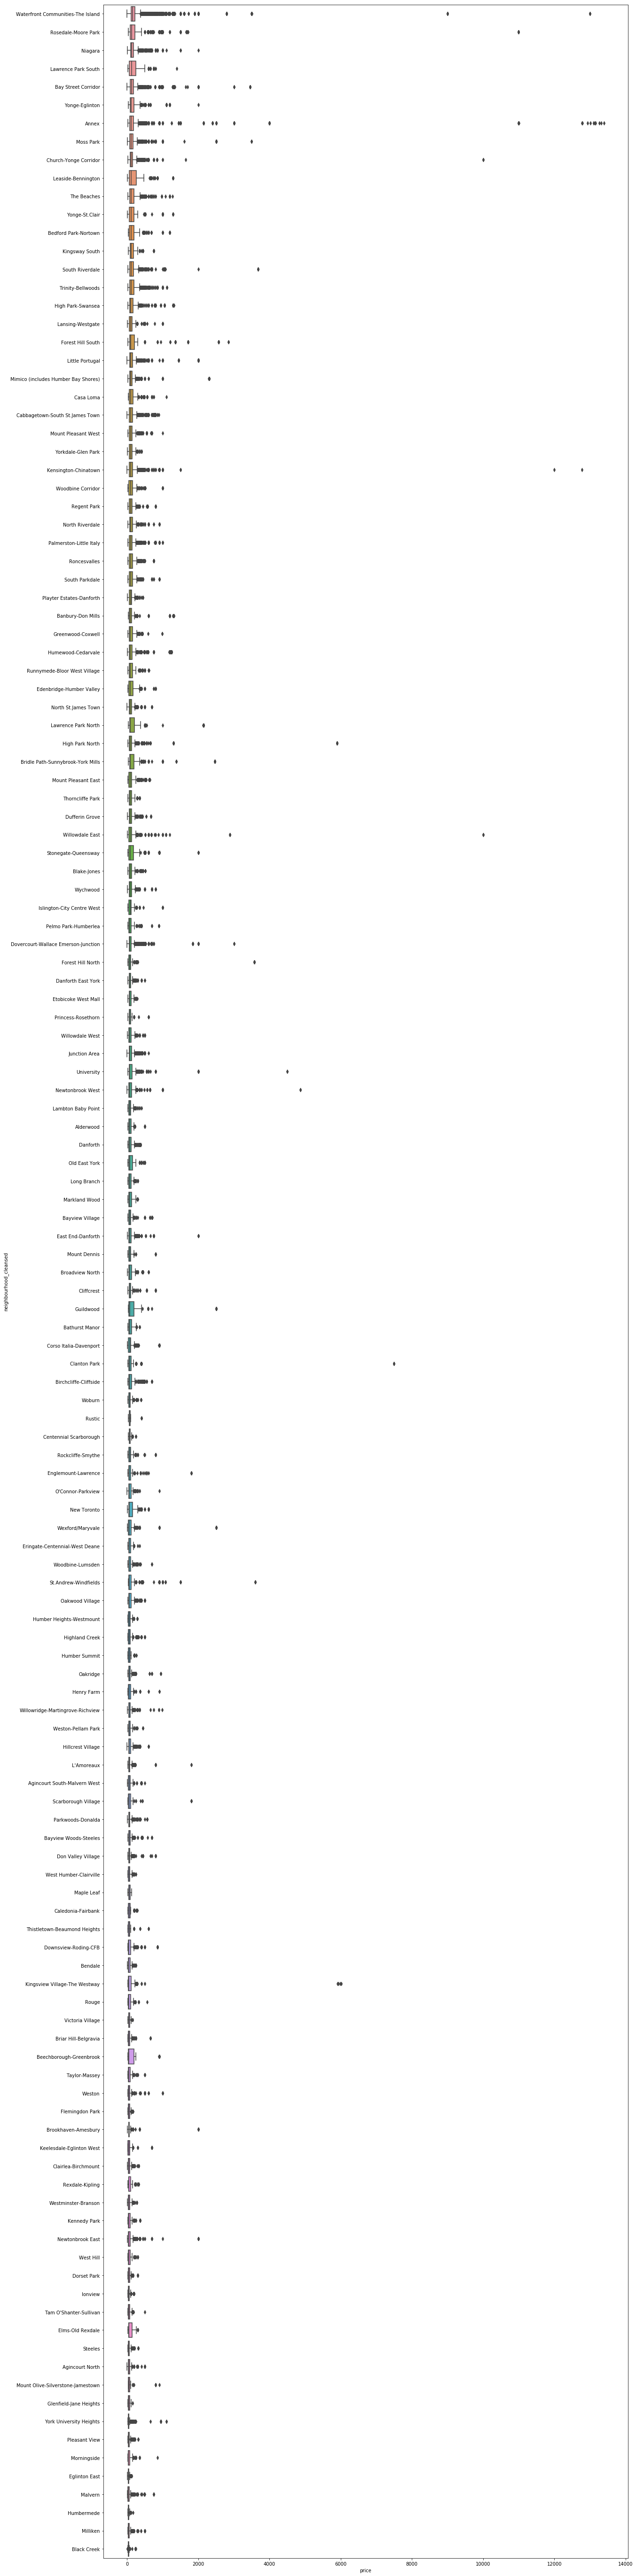

In [11]:
import matplotlib.ticker as ticker
sort_order = master_df.groupby('neighbourhood_cleansed')['price']\
                    .median()\
                    .sort_values(ascending=False)\
                    .index

plt.figure(figsize=(20,100))
#plt.rcParams['figure.dpi'] = 200
#sns.set_context("poster")
sns.boxplot(x='price', y='neighbourhood_cleansed', data=master_df, order=sort_order)

#ax = plt.gca()
#ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

#ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
#ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
                             
plt.show()

It looks like The Annex and Kensigton Market neighbourhoods have most of our price outliers. It this a concidence? I'm not sure but we will keep this in mind and hopefully we are going to be able to use this information in subsequent analysis.

Now let's try to see if there is any substantial difference between regular hosts and superhosts.

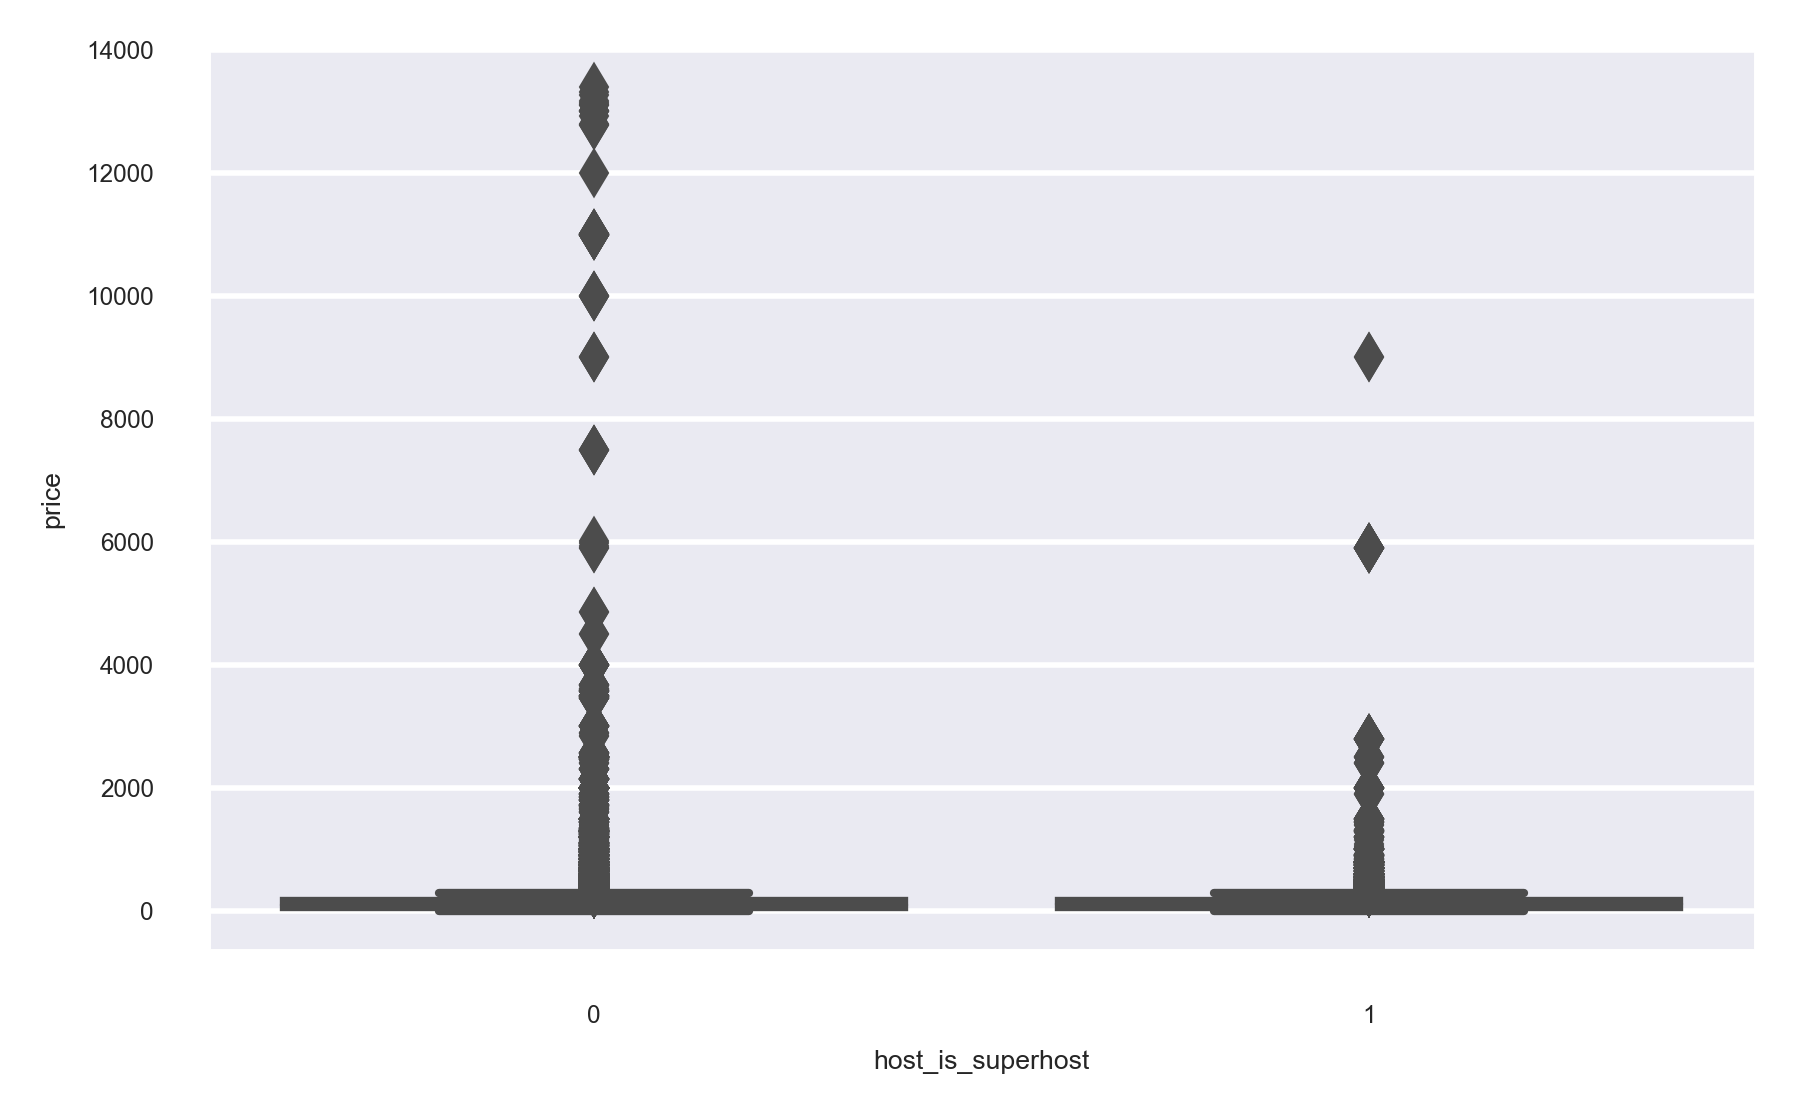

In [12]:
#plt.figure(figsize=(7.5, 4))
plt.rcParams['figure.dpi'] = 400
plt.figure(figsize=(5,3))
plt.rcParams.update({'font.size': 5})
sns.set(font_scale=0.4)
sns.boxplot(y='price', x='host_is_superhost', data=master_df)

Obviously the superhost category seems to generate a lot fewer outliers. According to airbnb the superhost has to meet additional criteria to be able to qualify as superhost.

We will plot the prices vs. property type. Let's see how many outliers have for each property type.

In [13]:
sort_order = master_df.groupby('property_type')['price']\
                    .median()\
                    .sort_values(ascending=False)\
                    .index
plt.figure(figsize=(20,100))
sns.set_context("paper", font_scale=2.0)
sns.boxplot(x='price', y='property_type', data=master_df, order=sort_order)
#ax = plt.gca()
#ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

The plot above gives us another important piece of information. It looks like condominiums have a lot more outliers than other property types. We should keep this in mind as well.

We should also check price outliers in regards with room type and bed type

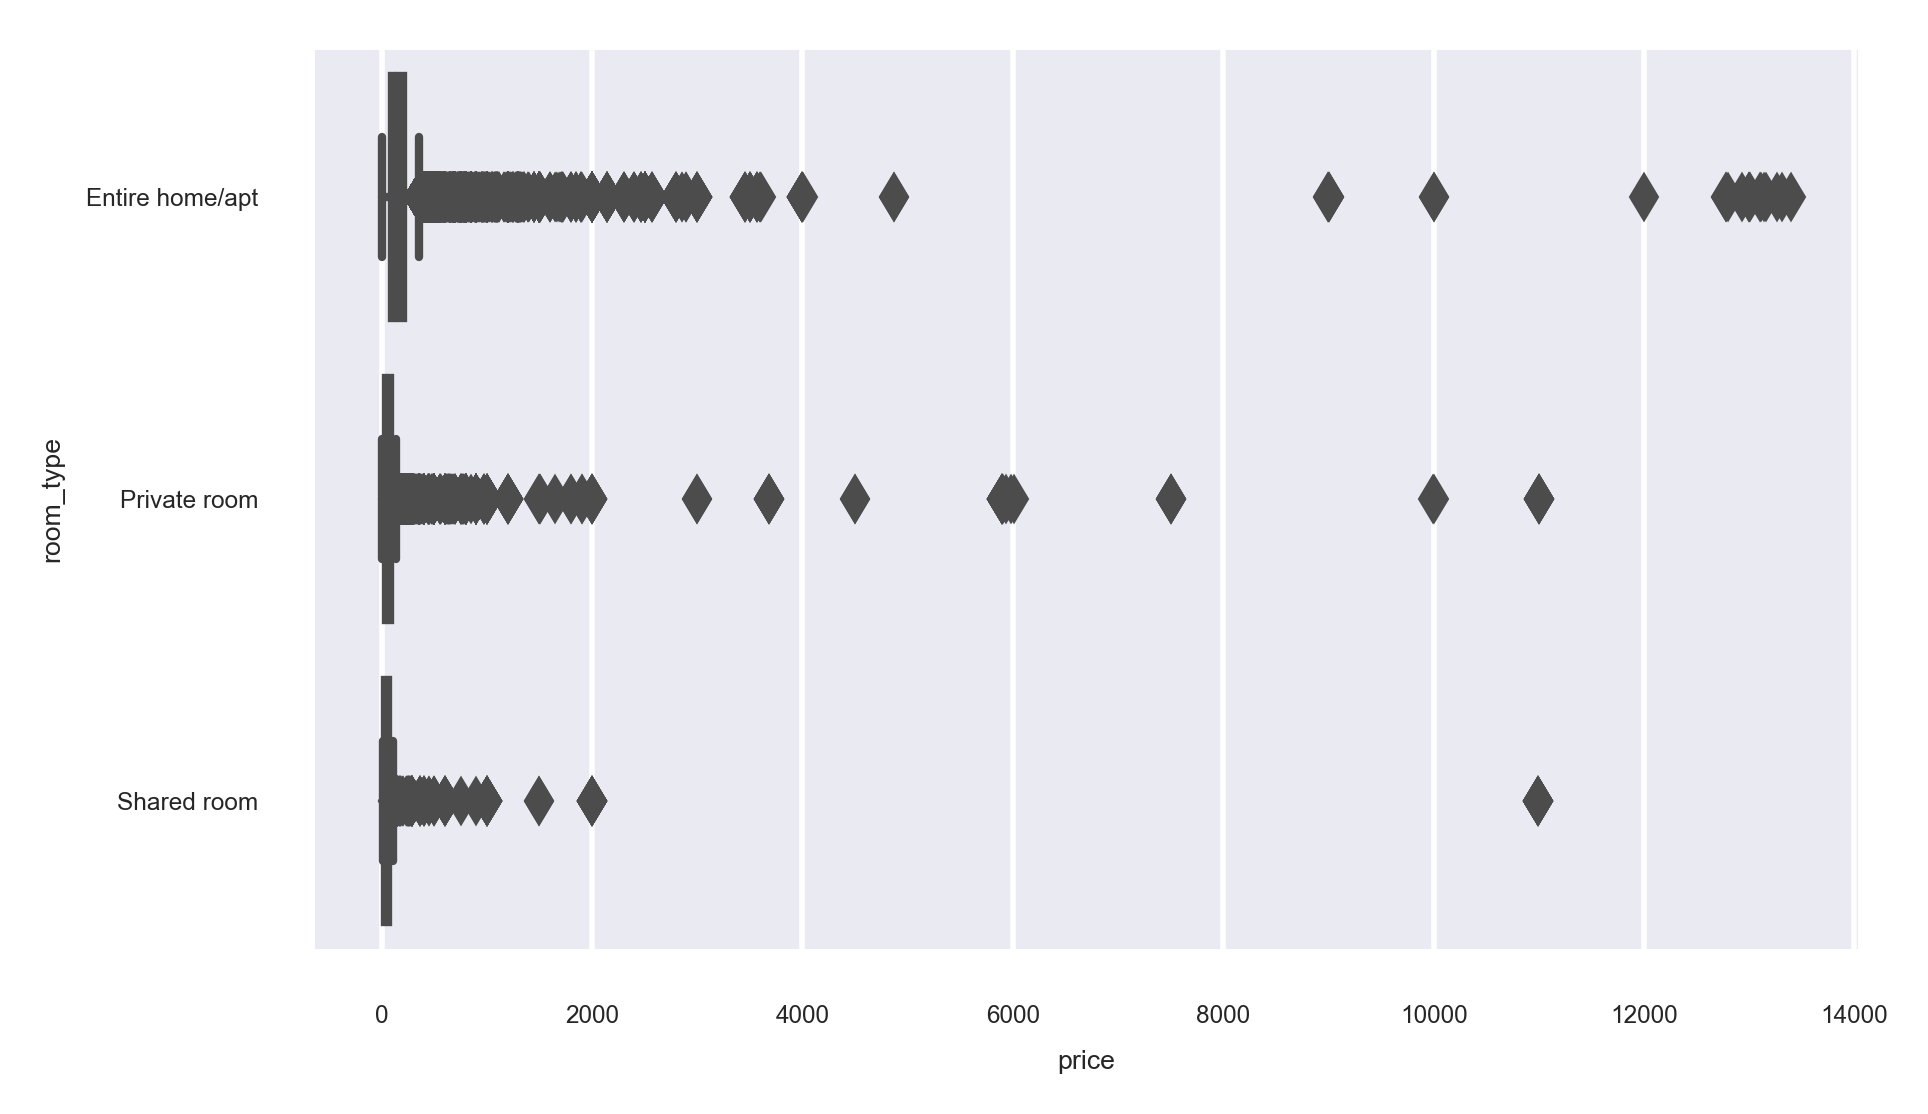

In [14]:
sort_order = master_df.groupby('room_type')['price']\
                    .median()\
                    .sort_values(ascending=False)\
                    .index

plt.figure(figsize=(5,3))
plt.rcParams.update({'font.size': 5})
sns.set(font_scale=0.4)

sns.boxplot(x='price', y='room_type', data=master_df, order=sort_order)

Interesting. We expected outliers for the "Entire home/apt" category but not for "Private room"/"Shared room". Another important information we should note.

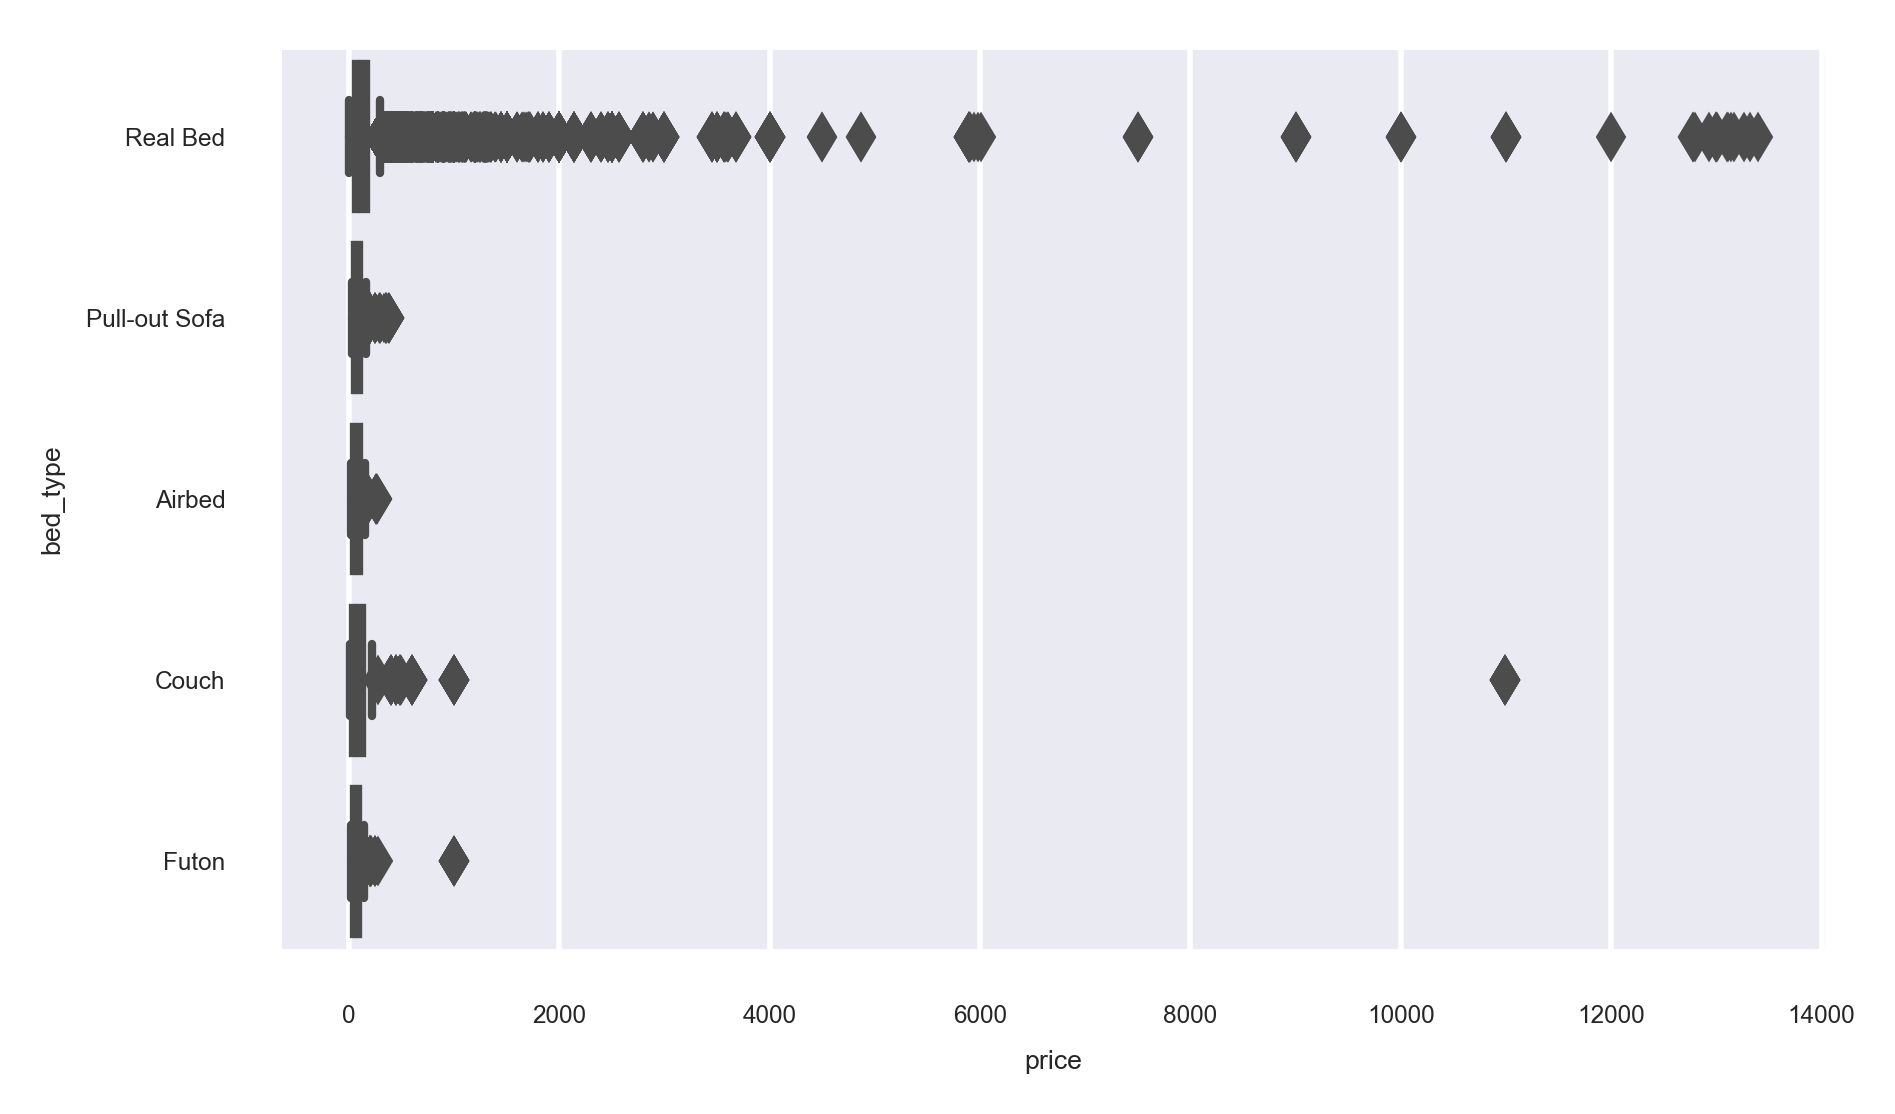

In [15]:
sort_order = master_df.groupby('bed_type')['price']\
                    .median()\
                    .sort_values(ascending=False)\
                    .index
plt.figure(figsize=(5,3))
plt.rcParams.update({'font.size': 5})
sns.set(font_scale=0.4)
sns.boxplot(x='price', y='bed_type', data=master_df, order=sort_order)

Here we have one couch listing that seems suspicious. 

The heatmap below represents the number of listings plotted vs number of bathrooms and number of bedrooms.

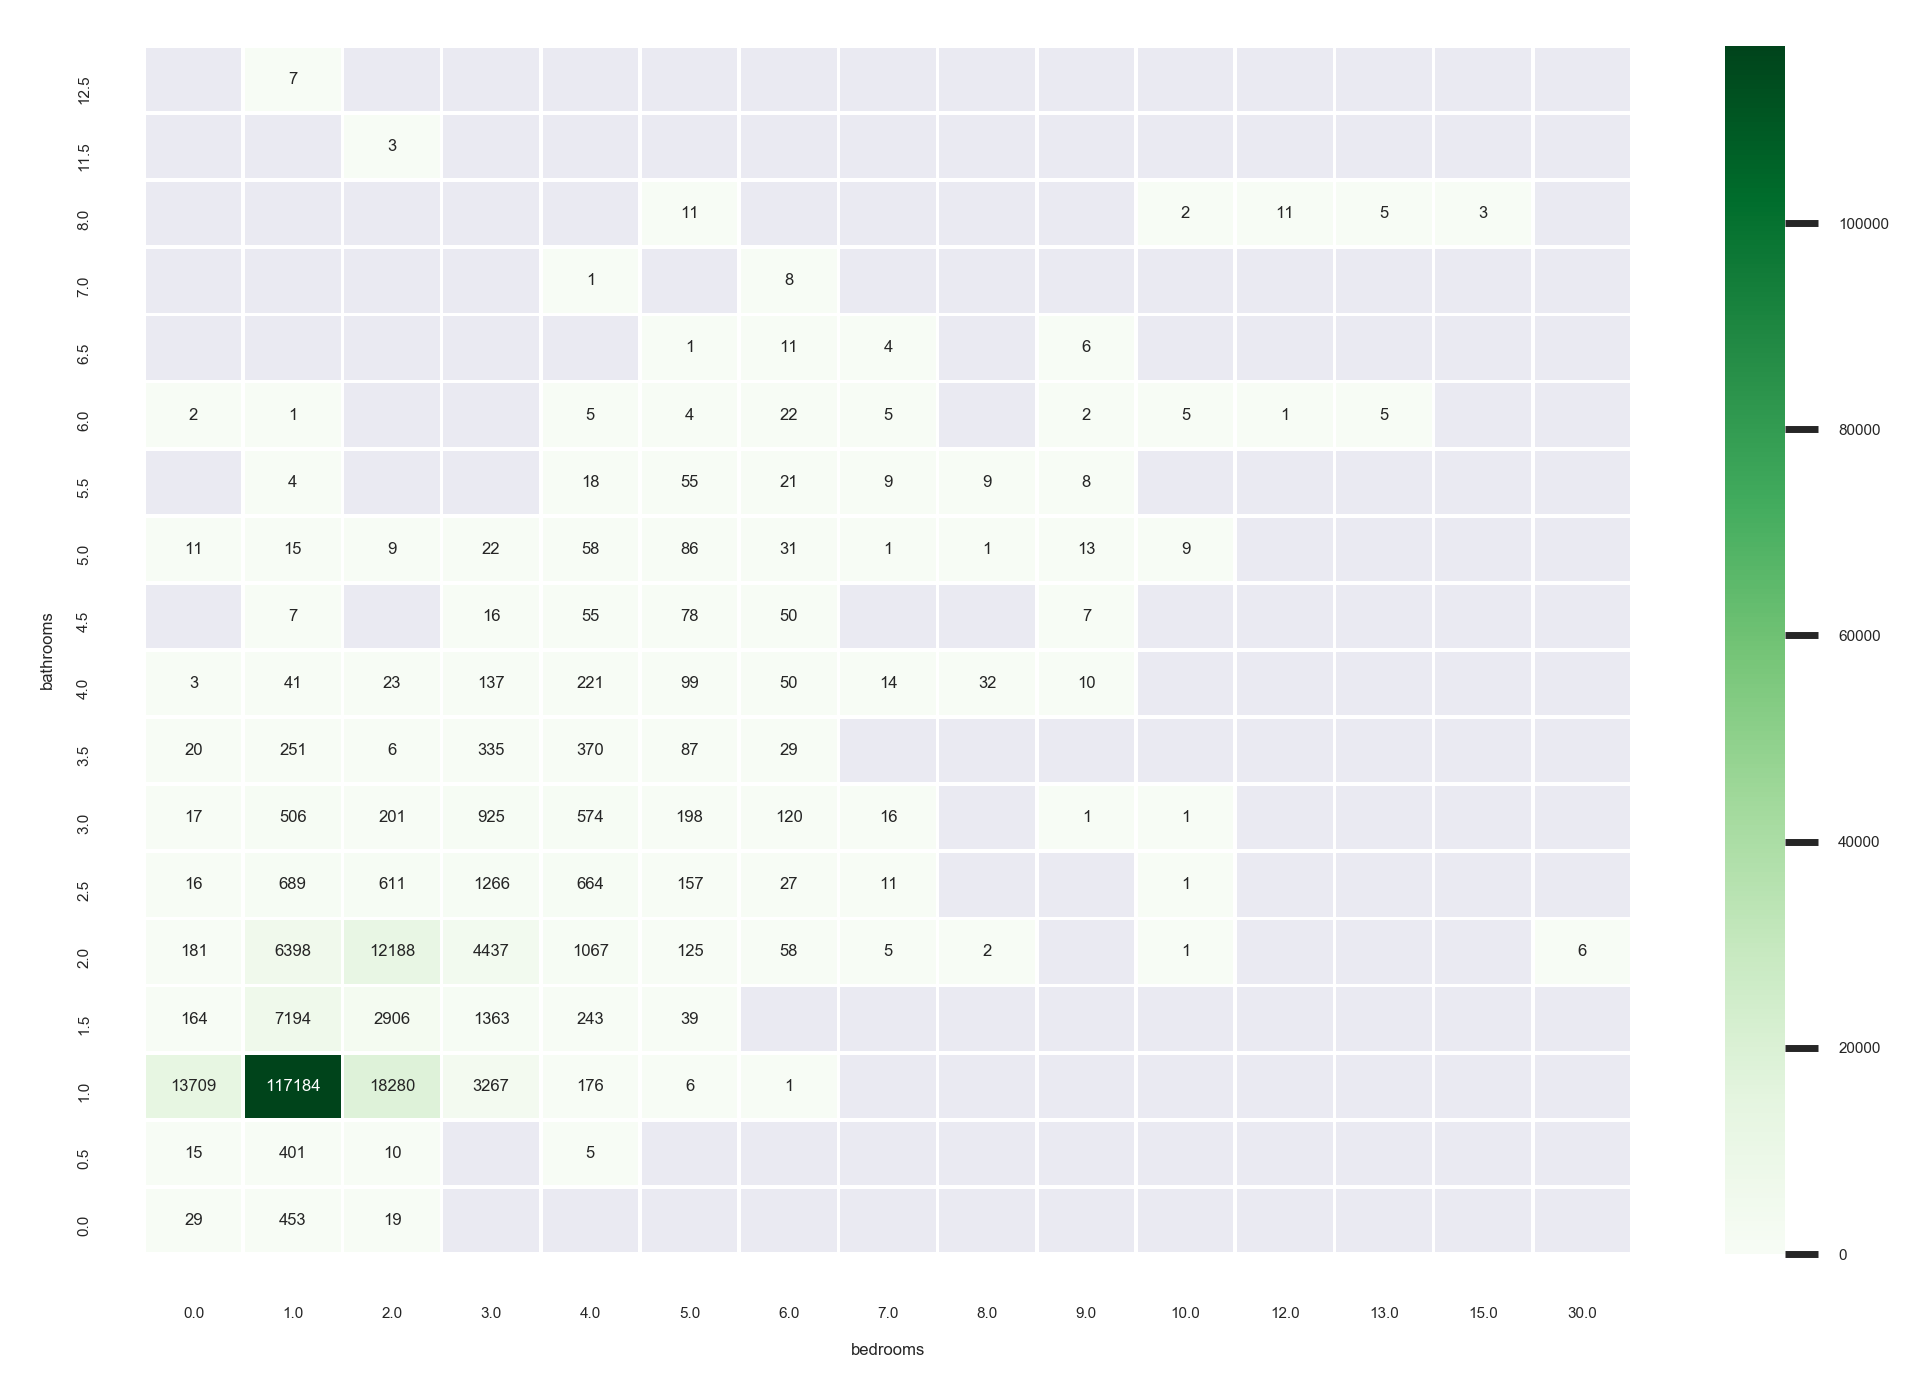

In [16]:
plt.rcParams.update({'font.size': 5})
sns.set(font_scale=0.25)
sns.heatmap(master_df.groupby(['bathrooms', 'bedrooms'])\
                .count()['price']\
                .reset_index()\
                .pivot('bathrooms', 'bedrooms', 'price')\
                .sort_index(ascending=False),
            cmap="Greens", fmt='.0f', annot=True, linewidths=0.5)

Interesting. I'm not sure if is a mistake or is something more but we seem to have a few listings that have only one bedroom and 12 bathrooms. Another piece of information that has to be used in later analysis. For all you know it might be even a message somebody is trying to send??

Here is a similar plot but this time is the price mean vs number of bathrooms and number of bedrooms.

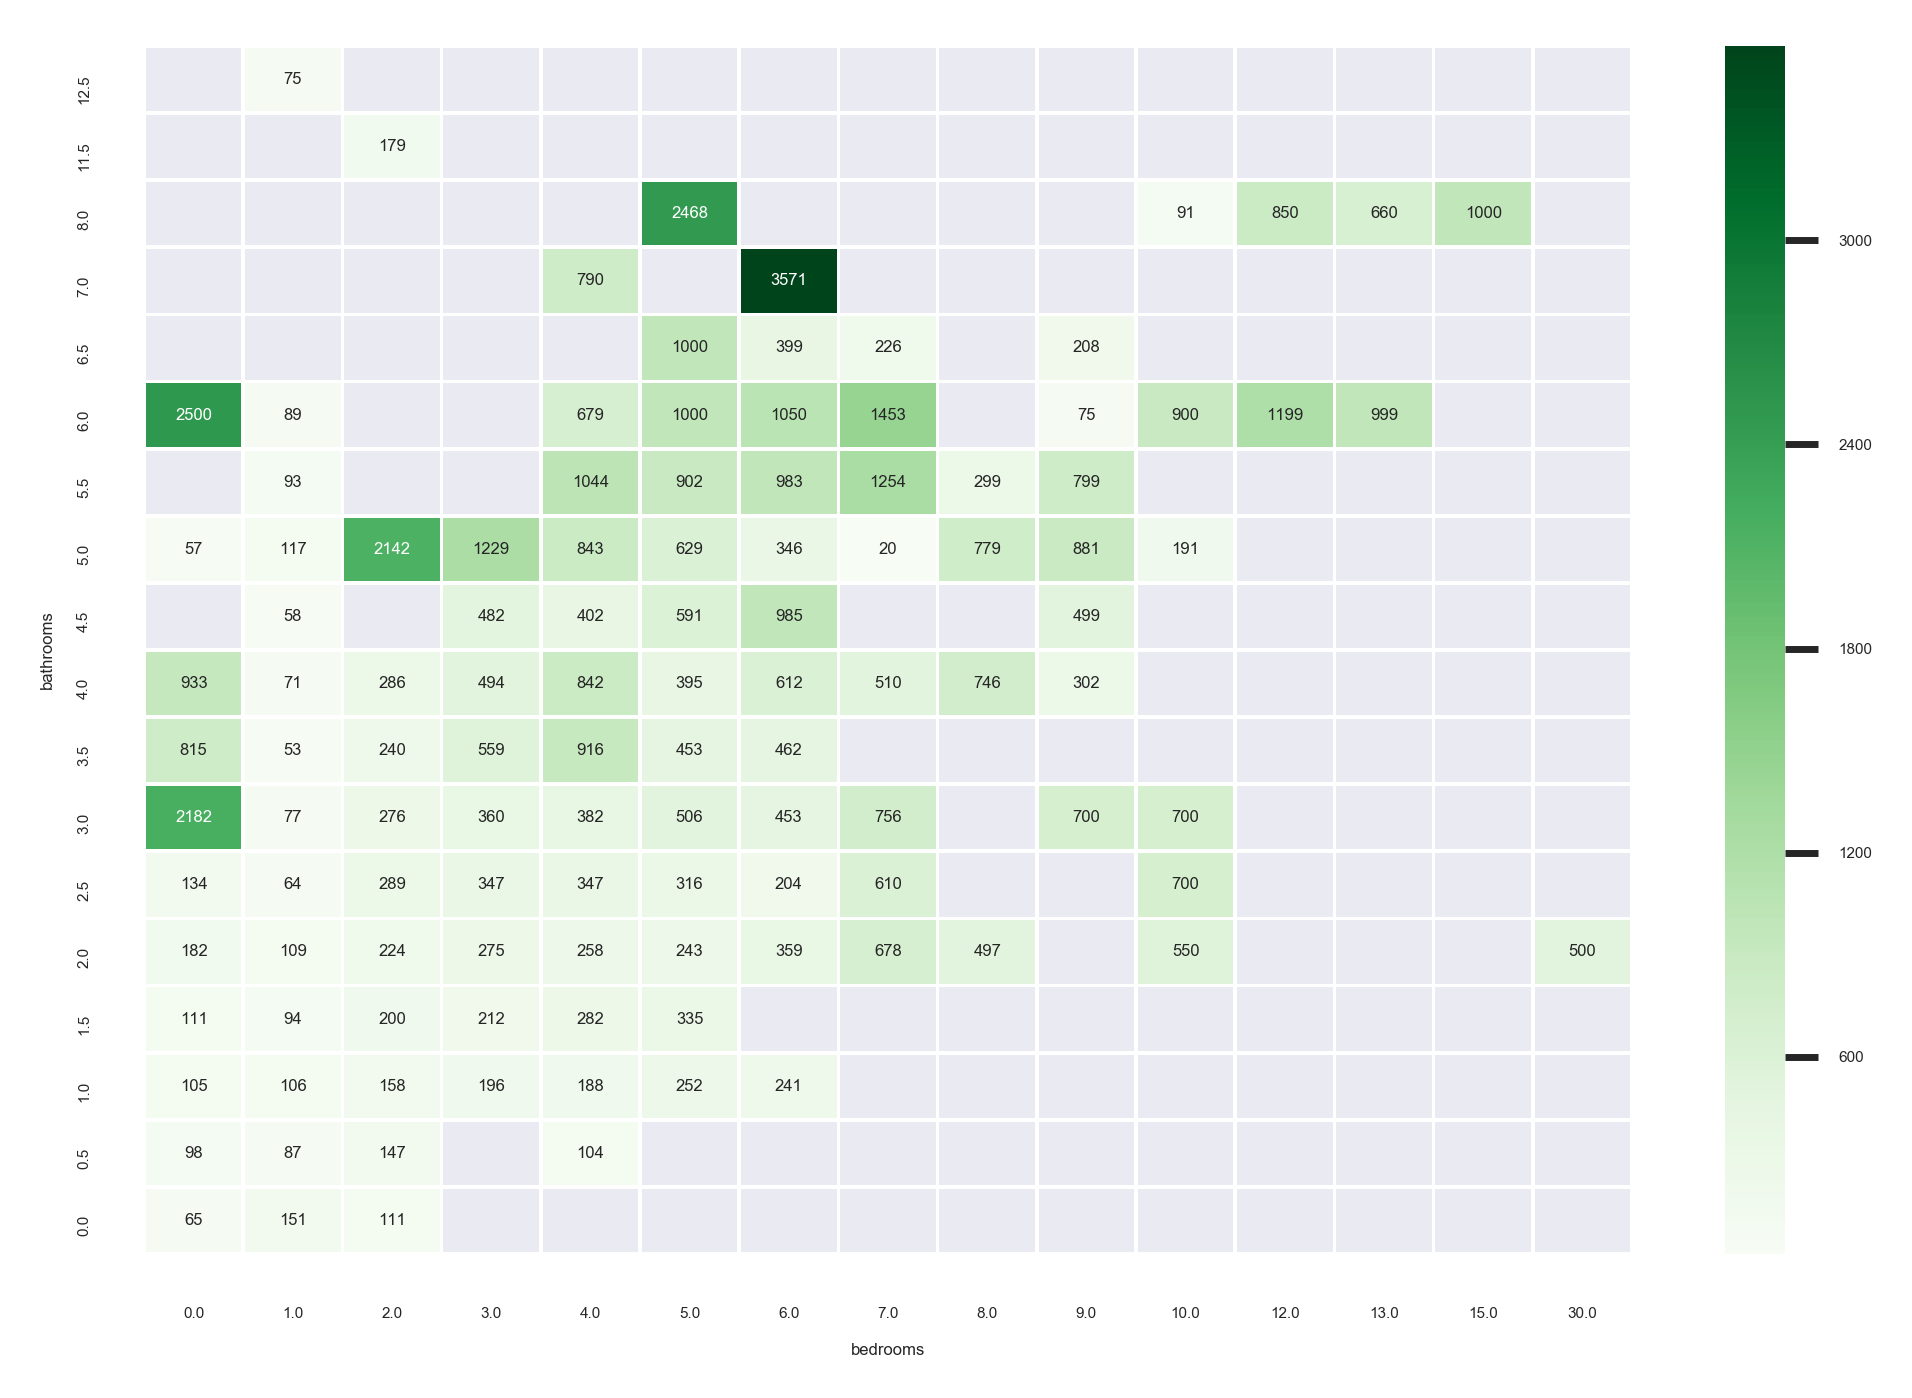

In [17]:
sns.heatmap(master_df.groupby(['bathrooms', 'bedrooms'])\
                .mean()['price']\
                .reset_index()\
                .pivot('bathrooms', 'bedrooms', 'price')\
                .sort_index(ascending=False),
            cmap="Greens", fmt='.0f', annot=True, linewidths=0.5)

The one bedroom/12 bathrooms category has a mean of only CAD 75/night. Is this a mistake or is something else?

Below we have another plot of price vs. number of beds offered

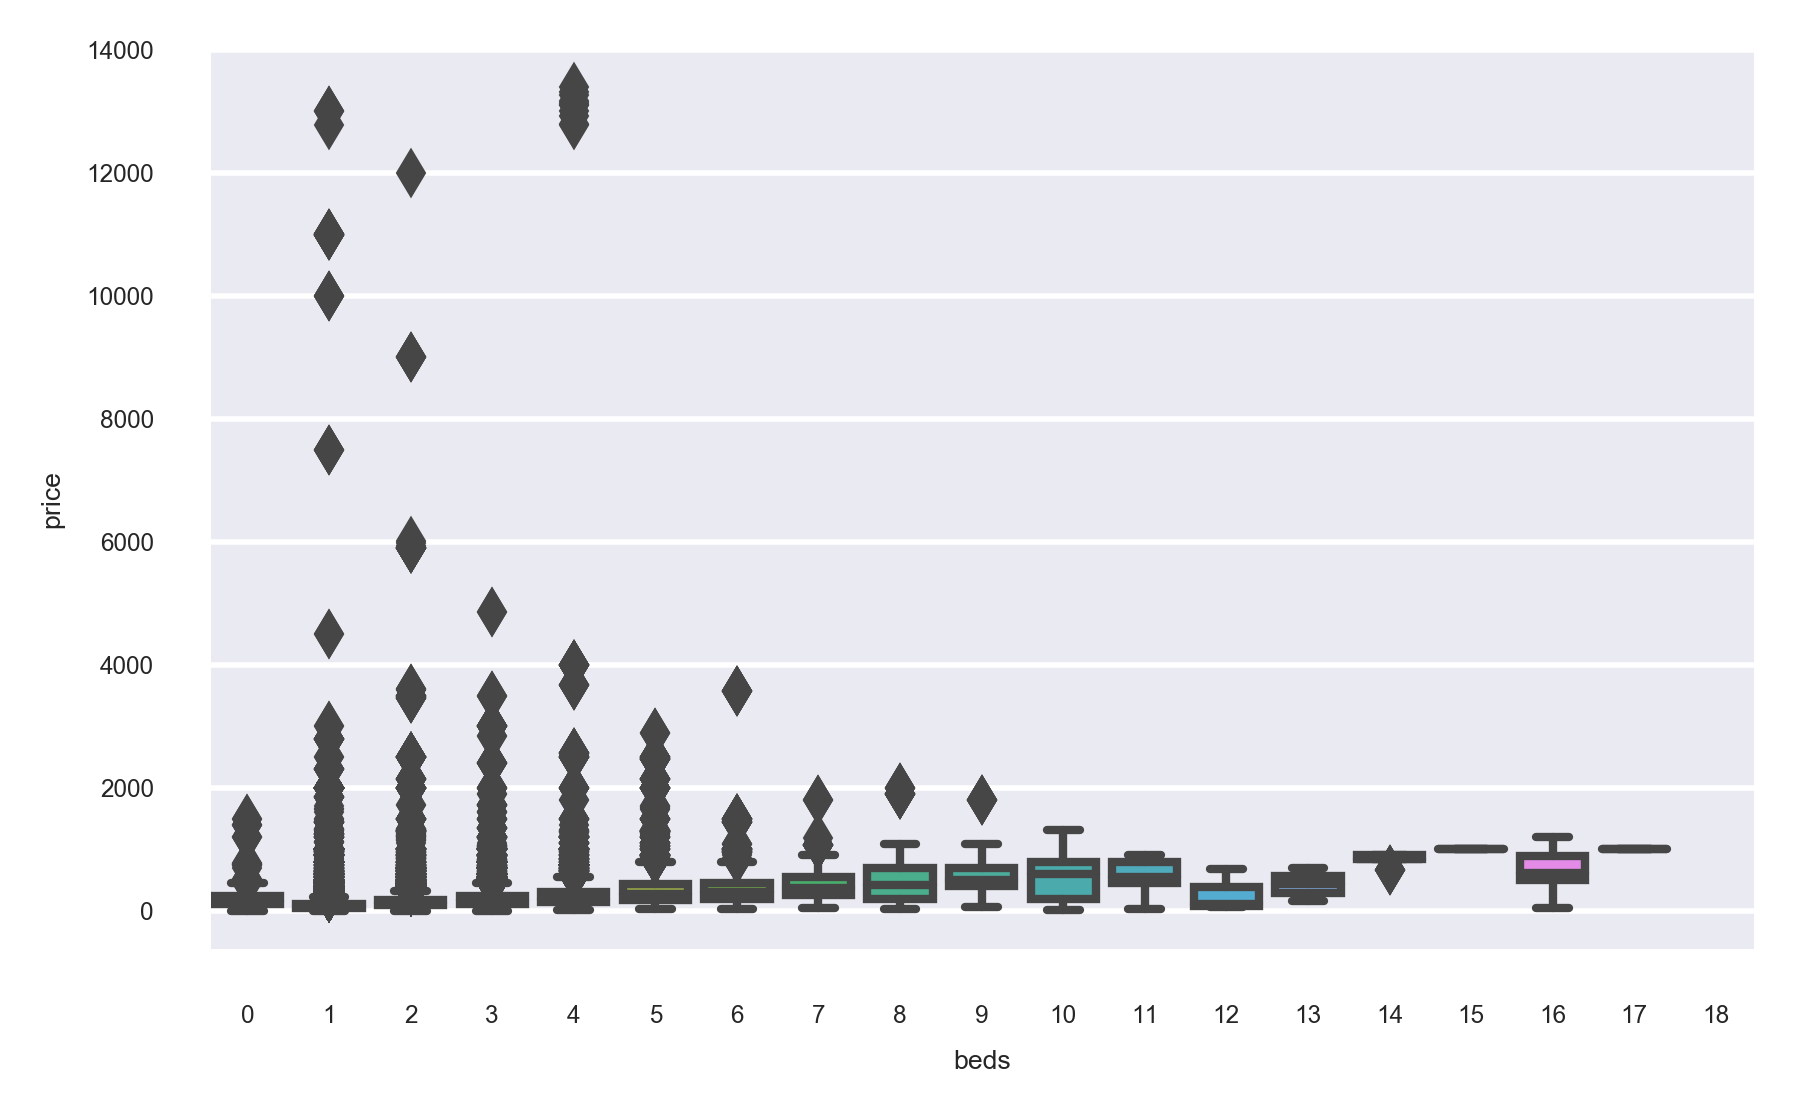

In [18]:
plt.figure(figsize=(5,3))
plt.rcParams.update({'font.size': 5})
sns.set(font_scale=0.4)
sns.boxplot(y='price', x='beds', data=master_df, order=range(0,19))

We observe potential anomalies in the plot above. Another piece of information we can use later.

Right now we are going to focus on prices. We would like to plot high priced properties (over CAD 3000/night) on a map

In [19]:
import folium
#master_df.reset_index(inplace=True)

myLat = 43.6823098050454
myLon = -79.3283423644293

city_map = folium.Map(location=[myLat,myLon], tiles="cartodbpositron", zoom_start=13)

for i in range(0,len(master_df)):
    if master_df.iloc[i]['price'] > 3000:
        
        pop_str = 'Host ID: ' + str(master_df.iloc[i]['host_id']) + "\n"
        pop_str += 'Host Name: ' + str(master_df.iloc[i]['host_name']) + "\n"
        pop_str += 'Host url: ' + str(master_df.iloc[i]['host_url']) + "\n"
        pop_str += 'Price: ' + str(master_df.iloc[i]['price']) + "\n"
        pop_str += 'Property type: ' + str(master_df.iloc[i]['property_type']) + "\n"
        pop_str += 'Listing url: ' + str(master_df.iloc[i]['listing_url']) + "\n"
        pop_str += 'Host is superhost: ' + str(master_df.iloc[i]['host_is_superhost'])
    
#        print(master_df.iloc[i]['price'])
        folium.Circle(
          location=[master_df.iloc[i]['latitude'], master_df.iloc[i]['longitude']],
          radius=master_df.iloc[i]['price']/400,
          popup=pop_str,
          color='crimson',
          fill=True,
          fill_color='crimson'
           ).add_to(city_map)
    


city_map

A brief analysis of the above map reveals that very high prices are being charged mostly by condominiums. Very interesting, do we see some kind of money laundering scheme going on in some cases? Let's try to plot on a map any property that would be available more than 250 days each year. This might reveal either professional AirBnB hosts or, maybe, something else?

<h3>Availability of Properties</h3>

In [20]:
import folium
myLat = 43.6823098050454
myLon = -79.3283423644297

days_map1 = folium.Map(location=[myLat,myLon], tiles="cartodbpositron", zoom_start=13)

for i in range(0,len(master_df)):
    if master_df.iloc[i]['availability_365'] > 300 and master_df.iloc[i]['price'] > 1000:
        pop_str = 'Host ID: ' + str(master_df.iloc[i]['host_id']) + "\n"
        pop_str += 'Host Name: ' + str(master_df.iloc[i]['host_name']) + "\n"
        pop_str += 'Host url: ' + str(master_df.iloc[i]['host_url']) + "\n"
        pop_str += 'Price: ' + str(master_df.iloc[i]['price']) + "\n"
        pop_str += 'Property type: ' + str(master_df.iloc[i]['property_type']) + "\n"
        pop_str += 'Listing url: ' + str(master_df.iloc[i]['listing_url']) + "\n"
        pop_str += 'Host is superhost: ' + str(master_df.iloc[i]['host_is_superhost'])

        folium.Circle(
          location=[master_df.iloc[i]['latitude'], master_df.iloc[i]['longitude']],
          radius=master_df.iloc[i]['price']/400,
          popup=pop_str,
          color='crimson',
          fill=True,
          fill_color='crimson'
           ).add_to(days_map1)
    

#print(count)
days_map1

Analyzing the listings plotted on the above maps we realise that in some cases some listings are phony and some hosts look not genuine. Maybe somebody should investigate phony hosts a bit deeper. We are going to try and run an SVM on the data with the hope that we can detect outliers(https://www.kaggle.com/lrthtn/potential-outliers-detection).

<h3>SVM Classifier</h3>

In [21]:
from sklearn import svm
from sklearn.covariance import EllipticEnvelope


def displayResults(inliers, outliers, classifier, outputTitle):
    
    plt.figure()        
    
    # Defining grid
    gridX, gridY = np.meshgrid(np.linspace(-0.5, 1.5, 1000), np.linspace(-0.5, 1.5, 1000))
    
    # Computing decision for each point of the grid
    gridDecisions = classifier.decision_function(np.c_[gridX.ravel(), gridY.ravel()])
    
    # Plotting decision boundary (each point of the grid whose decision value is 0)
    gridDecisions = gridDecisions.reshape(gridX.shape)
    plotBoundary = plt.contour(gridX, gridY, gridDecisions, levels=[0], linewidths=2, colors='blue')
    plt.clabel(plotBoundary, inline=1, fontsize=12)

    # Plotting inliers and outliers
    plt.scatter(inliers.loc[:, 'accommodates'], inliers.loc[:, 'price'], label="Inliers", color='green', alpha=0.2)
    plt.scatter(outliers.loc[:, 'accommodates'], outliers.loc[:, 'price'], label="Outliers", color='red', alpha=1.0)
    
    plt.xlabel("Accomodates (normalized)")
    plt.ylabel("Price (normalized)")
    plt.title(outputTitle)
    plt.legend()    
    plt.show()
    
def getClassifierRobustCovariance(data):

    #------------------------------------------------------------------------------
    # Checking prerequisites
    #------------------------------------------------------------------------------

    numberOfSamples = data.shape[0]
    numberOfFeatures = data.shape[1]
    
    if (numberOfSamples > numberOfFeatures ** 2):
        
        #------------------------------------------------------------------------------
        # Preparing and fitting model
        #------------------------------------------------------------------------------
        
        # Initializing classifier
        classifier = EllipticEnvelope(contamination=0.001)
        
        # Fitting classifier
        classifier.fit(data)
        
        return classifier
       
    return None


def getClassifierOneClassSVM(data):

    #------------------------------------------------------------------------------
    # Preparing and fitting model
    #------------------------------------------------------------------------------    
    
    # Initializing classifier
    classifier = svm.OneClassSVM(nu=0.003, gamma=2.0)
    
    # Fitting classifier
    classifier.fit(data)
    
    return classifier

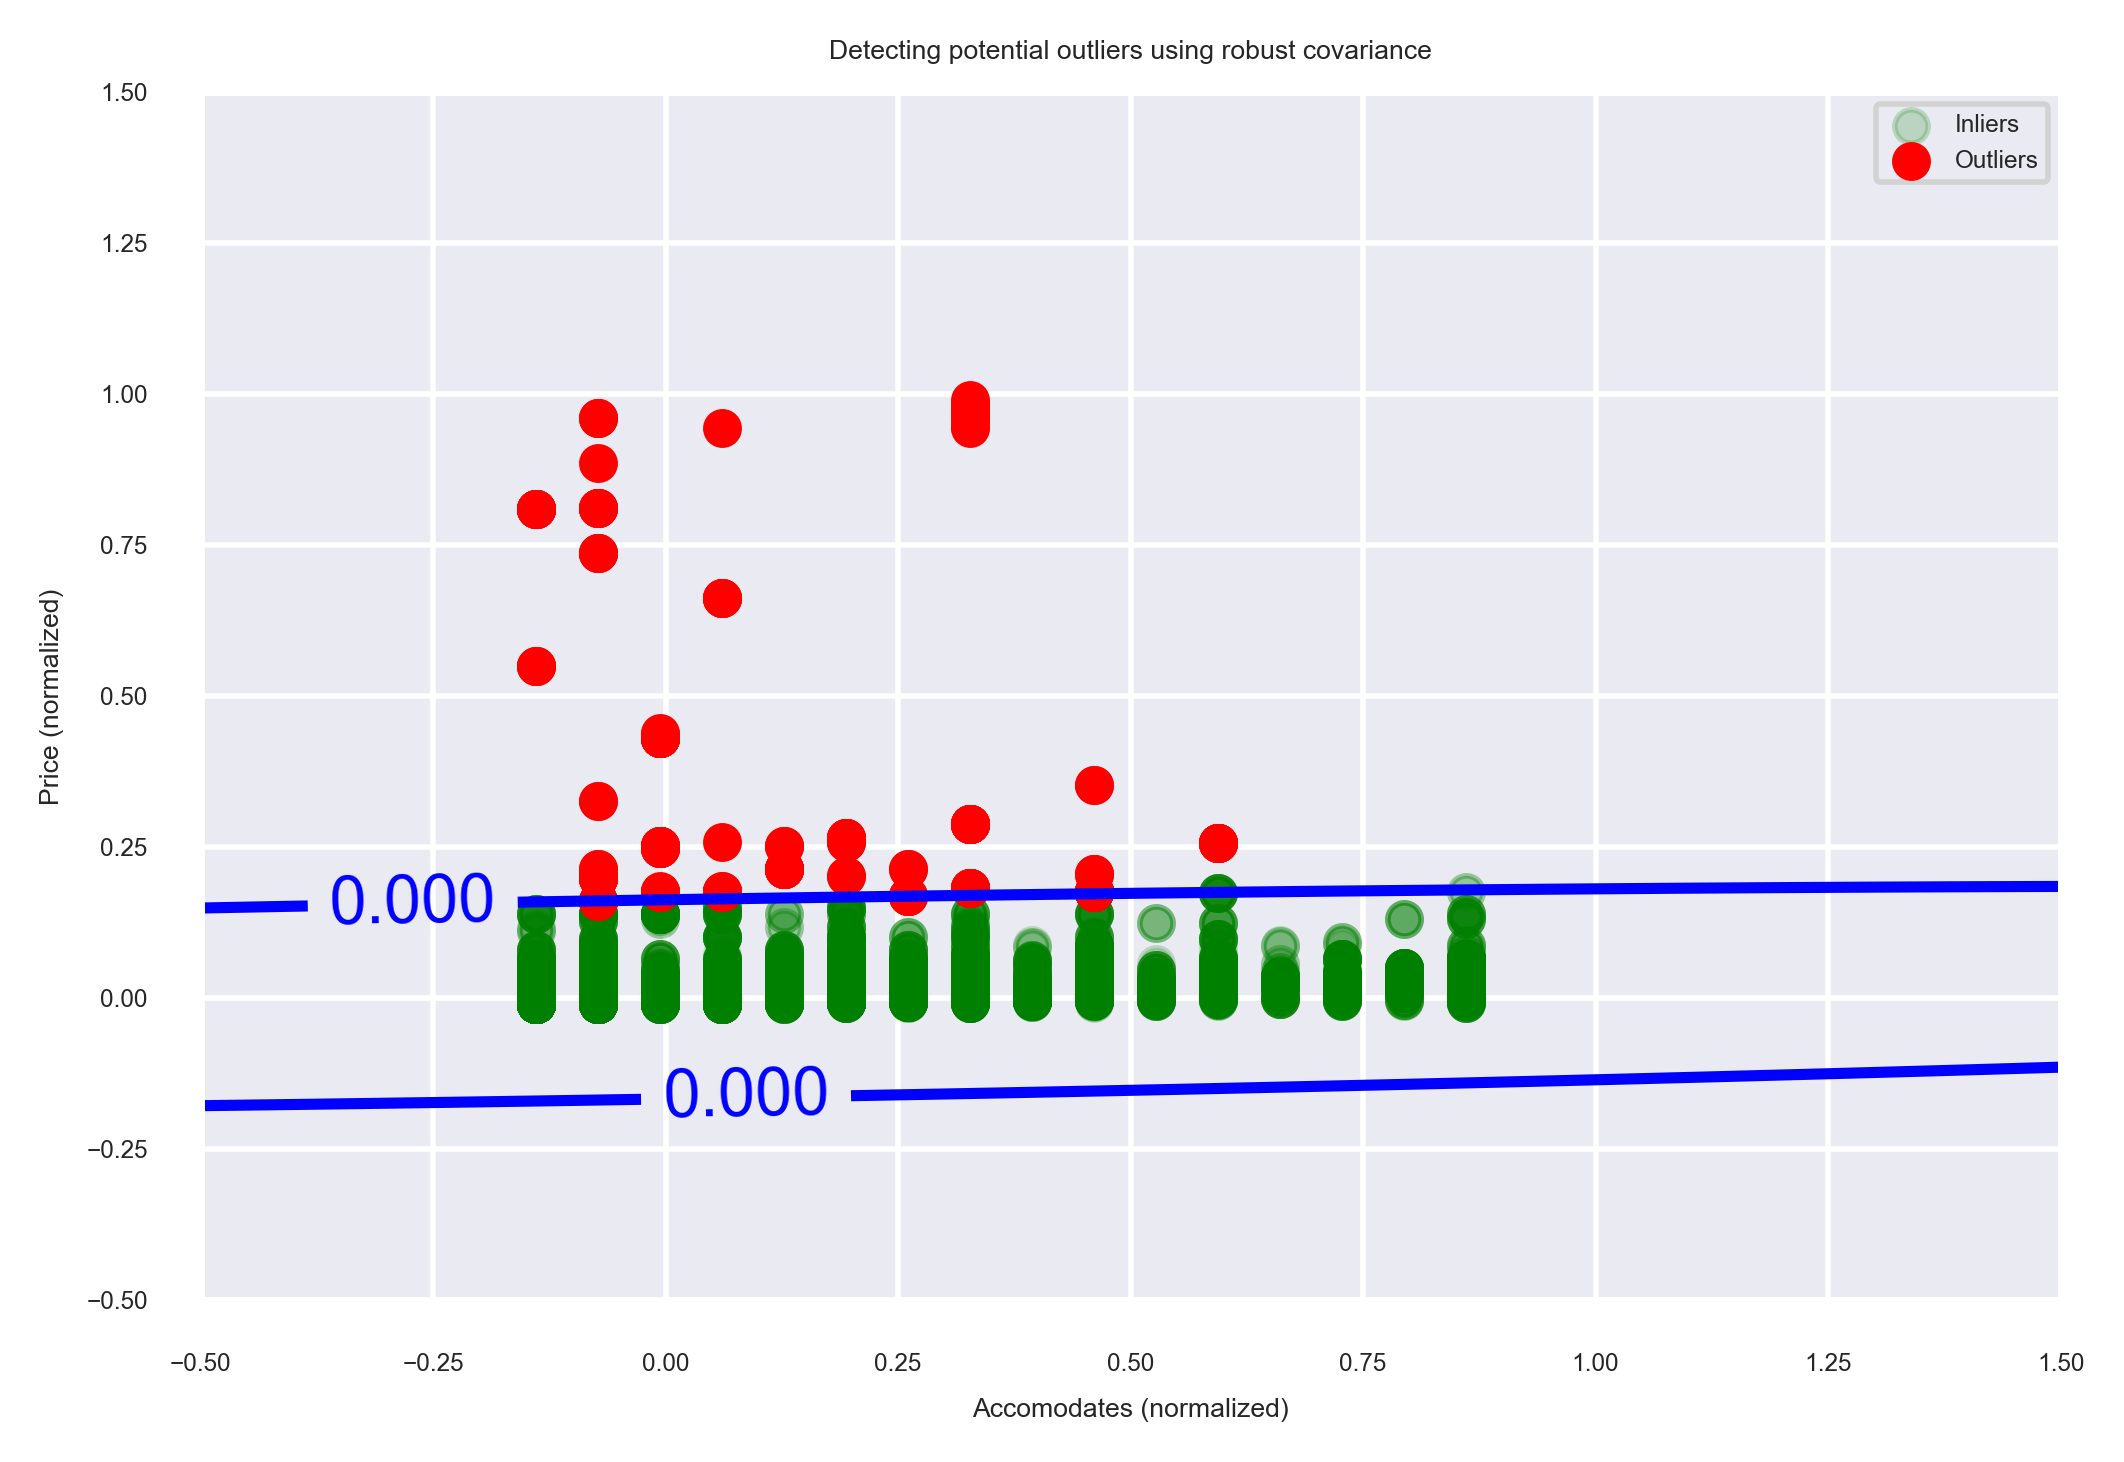

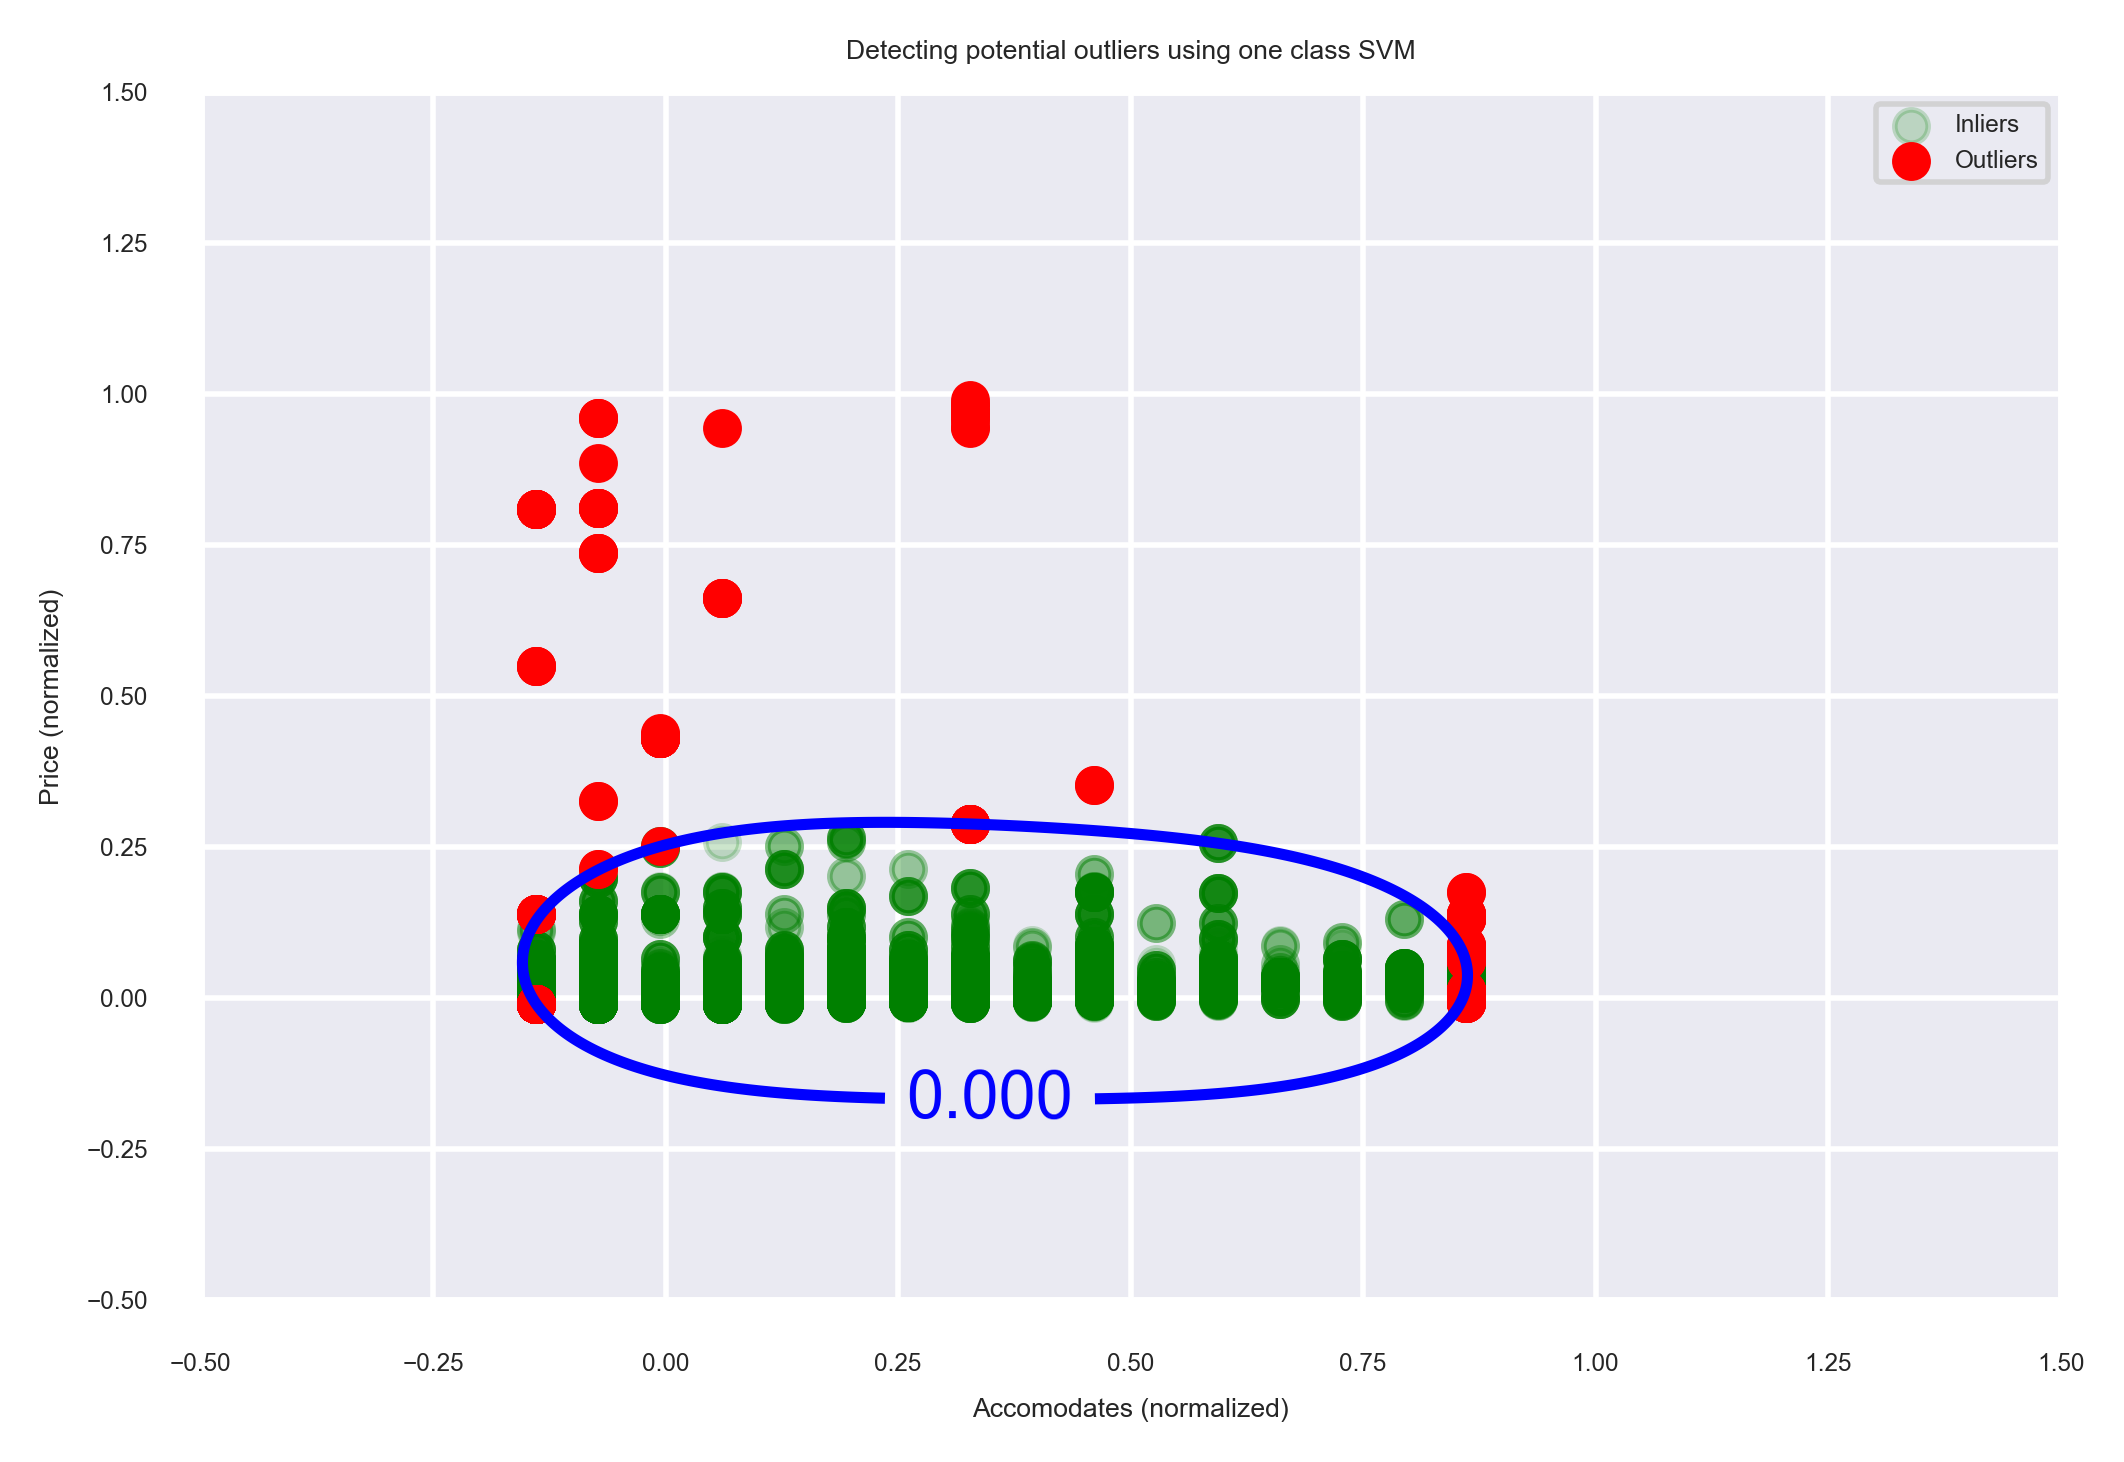

In [22]:


listings_features = master_df.loc[:, ['accommodates', 'price']]

# Fixing price column (removing unit, removing commas, converting to float)
#listings_features.loc[:, 'price'] = listings_features.loc[:, 'price'].apply(lambda x: x.replace('$','')).apply(lambda x: x.replace(',','')).astype(np.float)

# Normalizing features
listings_features = (listings_features - listings_features.mean()) / (listings_features.max() - listings_features.min())    

#------------------------------------------------------------------------------
# Detecting outliers with robust covariance
#------------------------------------------------------------------------------

# Getting classifier
classifierRobustCovariance = getClassifierRobustCovariance(listings_features)

# Classifying inliers/outliers
decisionsRobustCovariance = classifierRobustCovariance.decision_function(listings_features)

# Displaying results
displayResults(inliers=listings_features[decisionsRobustCovariance >= 0],
               outliers=listings_features[decisionsRobustCovariance < 0],
               classifier=classifierRobustCovariance,
               outputTitle = "Detecting potential outliers using robust covariance")

#------------------------------------------------------------------------------
# Detecting outliers with one class SVM
#------------------------------------------------------------------------------
# Getting classifier
classifierOneClassSVM = getClassifierOneClassSVM(listings_features)

# Classifying inliers/outliers
decisionsOneClassSVM = classifierOneClassSVM.decision_function(listings_features)

# Displaying results
displayResults(inliers=listings_features[decisionsOneClassSVM >= 0],
               outliers=listings_features[decisionsOneClassSVM < 0],
               classifier=classifierOneClassSVM,
               outputTitle = "Detecting potential outliers using one class SVM")


Interesting. We should probably try to understand the outliers in this data. What makes some listings much more different that the rest.

Now is time to cleanup the textual information and use this information to feed it trough __Google's Universal Sentence Encoder__ to generate features. These features will be used in a later analysis to try and spot unusual behaviour.

In [23]:
def ProcessTextData(sentence):
    text_data = sentence
    text_data = text_data.lower()
    #removes unicode strings
    text_data = re.sub(r'(\\u[0-9A-Fa-f])', r'', text_data)
    text_data = re.sub(r'[^\x00-\x7f]', r'', text_data)
    #convert any url to URL
    text_data = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text_data)
    #convert any @user to AT_USER
    text_data = re.sub('@[^\s]+', 'AT_USER', text_data)
    #remove additional white spaces
    text_data = re.sub('[\s]+', ' ', text_data)
    text_data = re.sub('[\n]+', ' ', text_data)
    #remove not alphanumeric symbols white spaces
    text_data = re.sub(r'[^\w]+', ' ', text_data)
    #remove numbers
    text_data = ''.join([i for i in text_data if not i.isdigit()])
    
    lemmatizer = WordNetLemmatizer()
    
    word_list = nltk.word_tokenize(text_data)
    
    stop_words = set(stopwords.words('english')) 
    
    filtered_sentence = [w for w in word_list if not w in stop_words]
    
# Lemmatize list of words and join
    text_data = ' '.join([lemmatizer.lemmatize(w) for w in filtered_sentence])

#    text_data = " ".join([Word(word).lemmatize for word in text_data.split()])
    #stemmer
#    st = PorterStemmer()
#   text_data = " ".join([st.stem(word) for word in text_data.split()])
    
    sentence = text_data
    return sentence

In [24]:
master_df['name'] = master_df['name'].apply(ProcessTextData)
master_df['summary'] = master_df['summary'].apply(ProcessTextData)
master_df['description'] = master_df['description'].apply(ProcessTextData)
master_df['amenities'] = master_df['amenities'].apply(ProcessTextData)

The code below has been used to generate features vectors for listings description. We plan to group listings in individual clusters and try to find unusual clusters. The features generated from description text will be used for clustering.

In [ ]:
import numpy as np 
import pandas as pd
import spacy
import re
from tqdm._tqdm_notebook import tqdm_notebook,tnrange,tqdm
from collections import Counter,OrderedDict
from gensim import models,corpora
from gensim.summarization import summarize,keywords
import warnings
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns

import pyLDAvis.gensim
from gensim.models.coherencemodel import CoherenceModel

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

import tensorflow as tf
import tensorflow_hub as hub
import csv



embed = hub.Module("../module_use")
# Compute a representation for each message, showing various lengths supported.
# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)
    

data_clean =  pd.read_csv('./data/generated/data_clean.csv.gz', low_memory=False, compression='gzip')

description_list = data_clean.description.fillna("aaabbb")

for i in range(len(description_list)):
    if len(description_list[i]) < 3:
        description_list[i] = 'aaabbb'

dl = description_list.tolist()

print(len(dl))

index_start = 0
index_end = 0

for ndx in range(187000, len(dl), 200):
    index_start = ndx
    index_end = ndx + 200
    
    if index_end > len(dl):
        index_end = len(dl)
        
    filename = 'desv_vec' + str(index_start) + '_' + str(index_end) + '.csv'
    
    print(filename)
    
    small_dl = dl[index_start:index_end]
    
    with tf.Session() as session:
        session.run([tf.global_variables_initializer(), tf.tables_initializer()])
        message_embeddings = session.run(embed(small_dl))
        
    with open(filename, 'a') as writeFile:
        writer = csv.writer(writeFile)
    
        for msge in message_embeddings:
            writer.writerow(msge)
        
    writeFile.close()

print('Done')        

Due to high memory consumption of the Universal Feature Encoder we had to run the above code on batches of data, then the features that have been generated have been appended to our dataframe. The code below has been used to merge the description features into our dataframe.

In [25]:
import csv
import numpy as np 
import pandas as pd
import string
import glob
import re

data_array = []

#get the list of CSV files starting with "desv_vec"
listing = glob.glob("../ml1030/text_vectors/desv_vec*.csv")
for filename in listing:
    #print(filename)
    try:
        with open(filename) as f:
            for line in f:
                data_array.append(line)
        
    except IOError:
        print('IOError: for file ', filename)
        raise


print('Done') 
print(len(data_array))

data_clean =  pd.read_csv('./data/generated/data_clean.csv.gz',low_memory=False, compression='gzip')


features_list = []
counter = 0
for line in data_array:
    #line = line.replace('\n', '')
    line = re.sub(r"\n+", "", line)
    features_list.append(line.split(','))
    counter += 1

del data_array
print('After loop')   

features_series = pd.Series(features_list)
del features_list
   
concatenated_data = pd.concat([data_clean, features_series], axis=1) 
#concatenated_data.to_csv('./data/generated/data_features_clean.csv')

print('Finished')

Done
198379
After loop
Finished


<h2><center>Reviews analysis</center></h2>

It's time now to look into listings reviews. Due to sheer volume of data we are going to load only one month of reviews and run our analysis on it. We will have to run this code for the entire year but this will have to be done on either GCP or Amazon.

In [26]:
import pandas as pd
from textblob import TextBlob
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [28]:
reviews = pd.read_csv("../data/reviews.csv")

In [ ]:
reviews.head()

Due to time constraints we will NOT run the code below in this notebook. We just wanted to show how the data cleaning has been done and how we have generated the similarity matrix.

In [ ]:
reviews["comments_cleaned"] = reviews["comments"].apply(ProcessTextData)
reviews.to_csv("reviews_cleaned.csv", index=False, header=True)

We notice above that the data contains listings id's, and reviewer id's beside the text of the review. We will use this information at a later time. 
We are going to use TextBlob to do some sentiment analysis and use this data later on.

In [29]:
reviews = pd.read_csv("./data/reviews_cleaned.csv")
reviews.head()

/home/silviu/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning:

Columns (0,2,4,5,8) have mixed types. Specify dtype option on import or set low_memory=False.



listing_id           id        date  reviewer_id reviewer_name  \
0       1419   38924112.0  2015-07-19   11308465.0       Marcela   
1       1419   44791978.0  2015-08-29    9580285.0         Marco   
2       1419   45957133.0  2015-09-07   38394721.0        Andrea   
3       1419   67295154.0  2016-03-28    3515044.0         Shaun   
4       1419  177702208.0  2017-08-03   13987100.0          Kate   

                                            comments  sentiment  subjectivity  \
0  Having the opportunity of arriving to Alexandr...   0.410104      0.699479   
1  We have no enough words to describe how beauty...   0.266667      0.683333   
2  The listing was exceptional and an even better...   0.576111      0.717361   
3  Alexandra's home was amazing and in such a nea...   0.295000      0.563333   
4  Beautiful home. Very comfortable and clean. Pe...   0.502963      0.740000   

                                    comments_cleaned  
0  opportunity arriving alexandra house describes...  
1  enough word describe beautyful cozy alexandra ...  
2  listing exceptional even better experience per...  
3  alexandra home amazing neat neighbourhood ever...  
4  beautiful home comfortable clean perfect famil...

__Reviews Clustering__

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [31]:
reviews["comments_cleaned"] = reviews["comments_cleaned"].astype(str)

In [32]:
comments = reviews["comments_cleaned"]

In [33]:
len(comments)

609669

As we can see above we have over 600000 review for a single month. The code below is the clustering implemented listings reviews.

<h4>Build the model</h4>

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(comments)

true_k = 50
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

<b>Pickle the model</b>

In [ ]:
import pickle
pickle.dump(model, open("model.bin","wb"))
pickle.dump(order_centroids, open("order_centroids.bin","wb"))
pickle.dump(terms, open("terms.bin","wb"))

<h4>Cluster the reviews</h4>

In [ ]:
review_cluster = []

for i in comments.index:    
    Y = vectorizer.transform([comments[i]])
    prediction = model.predict(Y)   
    review_cluster.append(prediction)
    
reviews["clusterid"] = [x[0] for x in review_cluster]
reviews.to_csv("./data/reviews_cluster.csv", index=False, header=True)

In [35]:
reviews_cluster = pd.read_csv("./data/reviews_cluster.csv")

/home/silviu/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning:

Columns (0,2,4,5,8) have mixed types. Specify dtype option on import or set low_memory=False.



In [36]:
reviews_cluster.head(1).T

0
listing_id                                                     1419
id                                                      3.89241e+07
date                                                     2015-07-19
reviewer_id                                             1.13085e+07
reviewer_name                                               Marcela
comments          Having the opportunity of arriving to Alexandr...
sentiment                                                  0.410104
subjectivity                                               0.699479
comments_cleaned  opportunity arriving alexandra house describes...
clusterid                                                        33

In [37]:
reviews_cluster["id"] = reviews_cluster["id"].astype(str)

In [38]:
import re
reviews_cluster["listing_id"] = reviews_cluster["listing_id"].apply(lambda x:re.sub(r"\s+", "", str(x)))

In [39]:
#Remove rows with null listing_id
reviews_cluster = reviews_cluster[reviews_cluster["listing_id"]!=""]

In [43]:
#exclude the nan in listing_id (just one record)
reviews_cluster = reviews_cluster[reviews_cluster["listing_id"]!="nan"]

In [44]:
reviews_cluster["listing_id"] = reviews_cluster["listing_id"].astype(int)

In [45]:
reviews_cluster["clusterid"].nunique()

50

In [46]:
reviews_cluster.head(10)

listing_id           id        date  reviewer_id   reviewer_name  \
0        1419   38924112.0  2015-07-19   11308465.0         Marcela   
1        1419   44791978.0  2015-08-29    9580285.0           Marco   
2        1419   45957133.0  2015-09-07   38394721.0          Andrea   
3        1419   67295154.0  2016-03-28    3515044.0           Shaun   
4        1419  177702208.0  2017-08-03   13987100.0            Kate   
5        1419  179394665.0  2017-08-07  111148735.0         Melissa   
6        1419  216619832.0  2017-12-04   46323833.0          Rachel   
7        8077       7830.0  2009-08-20      12750.0       Margarita   
8        8077       9941.0  2009-09-13      30020.0           Sunny   
9        8077      11995.0  2009-09-30      36786.0  Collin & Nandi   

                                            comments  sentiment  subjectivity  \
0  Having the opportunity of arriving to Alexandr...   0.410104      0.699479   
1  We have no enough words to describe how beauty...   0.266667      0.683333   
2  The listing was exceptional and an even better...   0.576111      0.717361   
3  Alexandra's home was amazing and in such a nea...   0.295000      0.563333   
4  Beautiful home. Very comfortable and clean. Pe...   0.502963      0.740000   
5  Alexandra was such an incredible host during o...   0.534048      0.764286   
6  The host canceled this reservation 22 days bef...   0.000000      0.000000   
7  We had a lovely time in Toronto! Kathie and La...   0.547222      0.605556   
8  Great hosts, great apartment and we loved stay...   0.588672      0.742188   
9  We really enjoyed staying at Kathie and Larry'...   0.427778      0.733333   

                                    comments_cleaned  clusterid  
0  opportunity arriving alexandra house describes...         33  
1  enough word describe beautyful cozy alexandra ...         33  
2  listing exceptional even better experience per...         33  
3  alexandra home amazing neat neighbourhood ever...          4  
4  beautiful home comfortable clean perfect famil...         33  
5  alexandra incredible host stay beautiful home ...         33  
6  host canceled reservation day arrival automate...          7  
7  lovely time toronto kathie larry great host wa...         42  
8  great host great apartment loved staying place...         25  
9  really enjoyed staying kathie larry place beat...          4

In [49]:
clustering_distribution = pd.pivot_table(reviews_cluster[["listing_id","clusterid"]],
                                           index=["clusterid"],
                                           aggfunc=np.count_nonzero).reset_index()


In [60]:
pd.pivot_table(reviews_cluster[["listing_id","clusterid"]],
                                           index=["clusterid"],
                                           aggfunc=pd.Series.nunique).reset_index()

clusterid  listing_id
0           0        2955
1           1          50
2           2        4797
3           3        6537
4           4        5425
5           5        3075
6           6        3978
7           7        3039
8           8        6224
9           9        3362
10         10        3603
11         11        3092
12         12        3417
13         13        6640
14         14        6010
15         15        4064
16         16        4929
17         17        4448
18         18        2980
19         19        5432
20         20        3236
21         21        3901
22         22          77
23         23        2729
24         24        3585
25         25        5038
26         26        3119
27         27        2808
28         28        2583
29         29        3778
30         30        3801
31         31        3564
32         32        3038
33         33        4858
34         34        2726
35         35        8812
36         36        3282
37         37        4047
38         38        5724
39         39        2903
40         40        2635
41         41        2915
42         42       11348
43         43        4608
44         44        1470
45         45        4854
46         46        3042
47         47        2792
48         48        4515
49         49        2539

In [52]:
clustering_distribution.columns = ["cluster_id", "num_reviews"]

In [55]:
clustering_distribution["% of total"] = clustering_distribution["num_reviews"] / clustering_distribution["num_reviews"].sum()
clustering_distribution = clustering_distribution.sort_values(by=["% of total"], ascending=False)
clustering_distribution

cluster_id  num_reviews  % of total
42          42        72050    0.132413
1            1        58059    0.106700
35          35        32202    0.059180
8            8        24418    0.044875
13          13        18924    0.034778
4            4        17256    0.031713
3            3        17242    0.031687
14          14        16793    0.030862
19          19        14878    0.027343
33          33        14669    0.026959
38          38        13273    0.024393
16          16        12799    0.023522
26          26        12650    0.023248
2            2        10354    0.019028
45          45        10350    0.019021
25          25         9785    0.017983
43          43         9717    0.017858
17          17         9202    0.016911
48          48         8647    0.015891
10          10         7493    0.013771
29          29         7348    0.013504
15          15         7249    0.013322
21          21         7113    0.013072
6            6         6983    0.012833
37          37         6801    0.012499
12          12         6742    0.012390
30          30         6490    0.011927
20          20         5718    0.010508
31          31         5708    0.010490
24          24         5691    0.010459
36          36         5513    0.010132
9            9         5448    0.010012
11          11         5446    0.010009
5            5         5292    0.009726
0            0         5206    0.009568
23          23         4901    0.009007
39          39         4818    0.008854
18          18         4768    0.008763
32          32         4738    0.008707
46          46         4735    0.008702
47          47         4626    0.008502
41          41         4580    0.008417
27          27         4320    0.007939
40          40         4291    0.007886
7            7         4262    0.007833
49          49         3970    0.007296
34          34         3964    0.007285
28          28         3728    0.006851
44          44         2223    0.004085
22          22          699    0.001285

In [62]:
reviews_cluster[reviews_cluster["clusterid"]==42]["listing_id"].nunique()

11348

In [64]:
reviews_cluster[reviews_cluster["clusterid"]==22].sort_values(by=["listing_id"])

listing_id           id        date  reviewer_id  reviewer_name  \
6353        454927   32399261.0  2015-05-17   32074936.0          Kevin   
17444      1143885    7505433.0  2013-09-23    1408649.0        Yasmine   
19505      1256759   23296148.0  2014-11-28   22657560.0      Alexandre   
19514      1256759   60329506.0  2016-01-22   51656796.0           Amel   
19520      1256759  180912899.0  2017-08-11   37682794.0           Nico   
22510      1486931  157119146.0  2017-06-02  125044454.0          Alina   
22507      1486931  144103696.0  2017-04-14    8476973.0          Peter   
22506      1486931  141271525.0  2017-04-02   15941142.0         Devaki   
22503      1486931  110337263.0  2016-10-25   26247222.0          Yamin   
22502      1486931  104699283.0  2016-09-28    5690856.0            Tom   
22498      1486931   87924211.0  2016-07-22   18840295.0        Jasmine   
22499      1486931   90614615.0  2016-08-01     432462.0           Matt   
22511      1486931  158820848.0  2017-06-08    8476973.0          Peter   
22497      1486931   82931606.0  2016-06-30    2138942.0        Jessica   
22496      1486931   77036365.0  2016-05-30    8731100.0           Ilya   
22495      1486931   73472478.0  2016-05-08   26246317.0       Patricia   
22501      1486931   98765072.0  2016-09-01   57450710.0      Dominique   
22512      1486931  160108571.0  2017-06-12   10911671.0         Shawna   
22521      1486931  206283171.0  2017-10-24  145735945.0         Sandra   
22517      1486931  181370728.0  2017-08-12  129644785.0      Sebastian   
22494      1486931   71378849.0  2016-04-25   67767338.0           Mark   
22522      1486931  232819327.0  2018-02-06    3155981.0          Elena   
22523      1486931  238677694.0  2018-02-26   21137012.0           Hugo   
22526      1486931  262041484.0  2018-05-07   17616319.0      Stephanie   
22527      1486931  270852427.0  2018-05-30     583489.0          Emily   
22528      1486931  278135716.0  2018-06-17  194382888.0          Reese   
22529      1486931  287724621.0  2018-07-08   18900100.0          Helen   
22530      1486931  302407638.0  2018-08-05   80341422.0          Nelly   
22532      1486931  314224244.0  2018-08-26  206029607.0  James Gilbert   
22533      1486931  318230603.0  2018-09-03    6235846.0         Maxime   
...            ...          ...         ...          ...            ...   
569011    26203978  368253518.0  2019-01-06  213904131.0         Gladcy   
570441    26338309  334594037.0  2018-10-09   74489377.0      Raphaëlle   
575001    26773291  400601520.0  2019-01-12  171016970.0          Jason   
579035    27172198  414062237.0  2019-02-18   24088663.0       Lori Lee   
582573    27525463  414743482.0  2019-02-20  234983865.0        Rogelio   
582572    27525463  365651647.0  2019-01-01   75499926.0        Stephen   
582571    27525463  356224719.0  2018-12-07  184680187.0        Antoine   
582569    27525463  351352234.0  2018-11-22   15059020.0        Michael   
582568    27525463  350036284.0  2018-11-18  195696588.0        Dorothy   
582567    27525463  346140642.0  2018-11-07  169511751.0          Tania   
582563    27525463  335624569.0  2018-10-12  184680187.0        Antoine   
582561    27525463  330511186.0  2018-09-30    3711214.0         Samuel   
582560    27525463  329347247.0  2018-09-28   77846645.0           Eric   
582559    27525463  328219544.0  2018-09-25   26116561.0      Sebastian   
582557    27525463  318340758.0  2018-09-03  136118150.0             旻洁   
582556    27525463  317127827.0  2018-09-01   88481193.0           Troy   
582553    27525463  309082031.0  2018-08-17  207743822.0       Nathalie   
582658    27544763  320984467.0  2018-09-09  211974764.0    Christopher   
582661    27544763  333627062.0  2018-10-07  214167965.0          Brian   
582671    27544763  401019777.0  2019-01-13  115323494.0          Donny   
582915    27551340  365680489.0  2019-01-01   39428430.0          Alena   
582914    27551340  353118495.0  

In [56]:
reviews_cluster[reviews_cluster["clusterid"]==42]

listing_id           id        date  reviewer_id   reviewer_name  \
7             8077       7830.0  2009-08-20      12750.0       Margarita   
10            8077      12177.0  2009-10-02      36703.0           Wendy   
12            8077      18890.0  2009-11-30      57824.0         Michele   
19            8077      43266.0  2010-05-17      88526.0             Don   
27            8077      85222.0  2010-08-26     206679.0           Tanya   
29            8077      93131.0  2010-09-08     187715.0           Susan   
34            8077     117380.0  2010-10-12     215842.0           Ethan   
37            8077     129599.0  2010-10-30     116155.0    Cy & Jeannie   
41            8077     141866.0  2010-11-20     243098.0           Tracy   
44            8077     149327.0  2010-12-06     260718.0            Jani   
46            8077     162496.0  2011-01-02     312798.0             Ken   
50            8077     194236.0  2011-03-07     329240.0            Gary   
54            8077     209732.0  2011-03-27     346859.0         Barbara   
57            8077     227647.0  2011-04-16     377713.0           Navin   
60            8077     251234.0  2011-05-04     462895.0         Richard   
66            8077     303668.0  2011-06-08     448724.0           Steve   
71            8077     349164.0  2011-07-03     233801.0  Joeline & Greg   
72            8077     354291.0  2011-07-05     625051.0           Srini   
73            8077     360396.0  2011-07-08     656240.0          Louise   
74            8077     368147.0  2011-07-12     524462.0            Dave   
80            8077     438928.0  2011-08-12     392524.0        Cristina   
82            8077     478529.0  2011-08-27     823338.0  Chris And Mary   
87            8077     530353.0  2011-09-14     682552.0            Mark   
89            8077     564346.0  2011-09-25     312586.0            Jane   
95            8077     610372.0  2011-10-09     396080.0          Fr Max   
97            8077     698315.0  2011-11-07     524762.0         Laverne   
99            8077     753090.0  2011-11-29    1272617.0         Aisling   
100           8077     825662.0  2012-01-02     183414.0     Christianna   
101           8077     890924.0  2012-01-30    1562232.0            John   
106           8077     991873.0  2012-03-12    1758193.0          Blaine   
...            ...          ...         ...          ...             ...   
609432    32318869  414509334.0  2019-02-19  108008098.0           Rishi   
609438    32319962  413546548.0  2019-02-17   22318740.0            John   
609461    32343309  414051078.0  2019-02-18   61389471.0            Adam   
609469    32362532  416477215.0  2019-02-24  223683674.0            Eric   
609470    32362532  417537462.0  2019-02-27  240452952.0           Frank   
609472    32362532  420421812.0  2019-03-06  243888635.0         Cassidy   
609473    32363055  412793959.0  2019-02-16  136053877.0            Remy   
609474    32363055  413998064.0  2019-02-18  127444591.0        Jennifer   
609476    32367054  414033542.0  2019-02-18  124717672.0          German   
609479    32371523  412807151.0  2019-02-16   14719670.0            Dung   
609492    32381906  415821784.0  2019-02-23  127402775.0            Paul   
609494    32381906  417532638.0  2019-02-27    4308472.0         Sumayya   
609509    32388073  417822935.0  2019-02-28  155968819.0            Lexi   
609516    32402962  417280132.0  2019-02-26   48574214.0         Yushuai   
609521    32408208  415044646.0  2019-02-21   41312652.0           Steve   
609524    32408725  415838954.0  2019-02-23  243779126.0        思桐(Kate)   
609532    32409197  415395337.0  2019-02-22   53927449.0           Corey   
609535    32409197  417514089.0  2019-02-27   51447393.0            Jane   
609558    32448661  415066719.0  2019-02-21   98831431.0           Venus   
609571    32469362  416533931.0  2019-02-24   24082331.0           David   
609573    32469362  419132127.0  2019-03-03   56140386.0

<center><h2>Group by property description features analysis</h2></center>

In this exercise we are going to group all listings based on features extracted from property description. We would like to visualize mean prices accross different groups in the hope that we are going to be able to spot some outliers.

First load data that has been already cleaned.

In [65]:
import numpy as np 
import pandas as pd
import nltk
from nltk.cluster import KMeansClusterer
import matplotlib.pyplot as plt

master_df = pd.read_csv('./data/generated/data_features_clean.csv.gz', low_memory=False, compression='gzip')

In [66]:
master_df.head().T

0  \
Unnamed: 0                                                                 0   
Unnamed: 0.1                                                               0   
id                                                                  24084526   
name                            large sunny room queen sized bed near subway   
summary                    private room luxury queen sized bed located qu...   
description                private room luxury queen sized bed located qu...   
host_id                                                            157408457   
host_name                                                      Lisa & Benson   
host_since                                                        2017-11-04   
host_location                                                             CA   
host_about                 Hi we are Lisa and Benson, \r\nWe welcome you ...   
host_is_superhost                                                          0   
host_listings_count                                                        7   
host_total_listings_count                                                  7   
host_identity_verified                                                     0   
street                                                   Toronto, ON, Canada   
neighbourhood                                        York University Heights   
neighbourhood_cleansed                               York University Heights   
latitude                                                             43.7526   
longitude                                                           -79.5077   
is_location_exact                                                          1   
property_type                                                          House   
room_type                                                       Private room   
accommodates                                                               2   
bathrooms                                                                  1   
bedrooms                                                                   1   
beds                                                                       1   
bed_type                                                            Real Bed   
amenities                  wifi air conditioning kitchen free parking pre...   
price                                                                     40   
guests_included                                                            1   
extra_people                                                              10   
availability_365                                                         171   
desc_features              ['-0.106930874', '-0.03466785', '-0.037711095'...   

                                                                           1  \
Unnamed: 0                                                                 1   
Unnamed: 0.1                                                               1   
id                                                                  23663025   
name                                      room york university subway around   
summary                    bright room york university subway store resta...   
description                bright room york university subway store resta...   
host_id                                                             43488381   
host_name                                                            Runying   
host_since                                                        2015-09-06   
host_location                                                             CA   
host_about                 I have been Professional landlord for 17 years...   
host_is_superhost                                                          0   
host_listings_count                                                       33   
host_total_listings_count                                                 33   
host_identity_verified                                                    

As we can see above two indexed have been added to the datafram. We don't need them.

In [70]:
master_df.columns

Index(['index', 'id', 'name', 'summary', 'description', 'host_id', 'host_name',
       'host_since', 'host_location', 'host_about', 'host_is_superhost',
       'host_listings_count', 'host_total_listings_count',
       'host_identity_verified', 'street', 'neighbourhood',
       'neighbourhood_cleansed', 'latitude', 'longitude', 'is_location_exact',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'bed_type', 'amenities', 'price', 'guests_included',
       'extra_people', 'availability_365', 'desc_features'],
      dtype='object')

We know that the description features contained in our dataframe have been loaded as strings. We will have to clean up this and format it so that at the end we have an array of floating point numbers that can be used as our features vectors.

In [71]:
master_df.loc[:, 'desc_features'] = master_df.loc[:, 'desc_features'].apply(lambda x: x.replace('[','')).apply(lambda x: x.replace(']',''))
master_df.loc[:, 'desc_features'] = master_df.loc[:, 'desc_features'].apply(lambda x: x.replace('\'','')).apply(lambda x: x.replace(',',' '))
master_df.loc[:, 'desc_features'] = master_df.loc[:, 'desc_features'].apply(lambda x: x.replace('  ',' '))
master_df['desc_features'] = master_df['desc_features'].apply(lambda x : [float(i) for i in x.split(' ')])
master_df['desc_features'] = master_df['desc_features'].apply(lambda x : np.asarray(x))

In [72]:
X = master_df['desc_features']

In [74]:
NUM_CLUSTERS=10

kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25, avoid_empty_clusters=True)
assigned_clusters = kclusterer.cluster(X, assign_clusters=True)

In [75]:
print(len(assigned_clusters))

198379


In [ ]:
import csv

csv_file = open('clusters.csv', "w")

columnTitleRow = "cluster\n"
csv_file.write(columnTitleRow)

for key in assigned_clusters:
    row = str(key) + "\n"
    csv_file.write(row)
    
csv_file.close()

Since we have the clusters let's check how many listings each cluster contains.

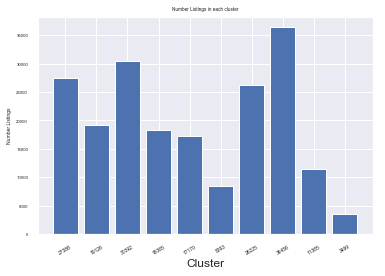

In [76]:
master_df['cluster'] = assigned_clusters
data_groups = master_df.groupby(["cluster"]).count().reset_index()[["cluster","id"]].sort_values(by=["id"],ascending=False).reset_index(drop=True)

plt.bar(data_groups['cluster'], data_groups['id'])
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Number Listings', fontsize=5)
plt.xticks(data_groups['cluster'], data_groups['id'], fontsize=5, rotation=30)
plt.title('Number Listings in each cluster')
plt.show()

Interesting. We have a couple of clusters that contain a lot fewer listings than most clusters. Maybe it's time to check median price distribution across clusters.

In [77]:
price_groups = master_df.groupby(["cluster"])[["price"]].median().reset_index()

In [78]:
price_groups.head().T

0     1      2     3     4
cluster   0.0   1.0    2.0   3.0   4.0
price    78.0  84.0  120.0  80.0  92.0

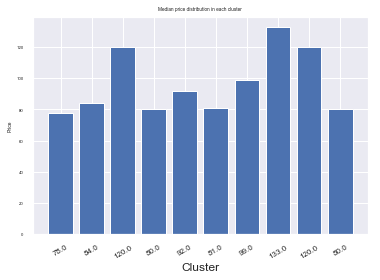

In [79]:
plt.bar(price_groups['cluster'], price_groups['price'])
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Price', fontsize=5)
plt.xticks(price_groups['cluster'], price_groups['price'], fontsize=8, rotation=30)
plt.title('Median price distribution in each cluster')
plt.show()

Now, we have the median price. Maybe is time to check the maximum price distribution.

In [80]:
max_price_groups = master_df.groupby(["cluster"])[["price"]].max().reset_index()

In [81]:
max_price_groups.head().T

0       1       2        3       4
cluster     0.0     1.0     2.0      3.0     4.0
price    5901.0  3680.0  9001.0  12779.0  3000.0

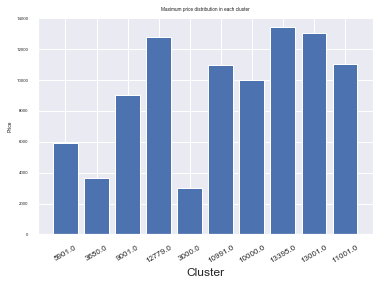

In [82]:
plt.bar(max_price_groups['cluster'], max_price_groups['price'])
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Price', fontsize=5)
plt.xticks(max_price_groups['cluster'], max_price_groups['price'], fontsize=8, rotation=30)
plt.title('Maximum price distribution in each cluster')
plt.show()

This might be interesting. Why only some groups have such a high price. We should probably look into the wording used for listing description. Some clusters seem to have outrageously high prices. Why?
Let's look into minimum price for each cluster.

In [83]:
min_price_groups = master_df.groupby(["cluster"])[["price"]].min().reset_index()

In [84]:
min_price_groups.head().T

0    1    2    3    4
cluster  0.0  1.0  2.0  3.0  4.0
price    0.0  0.0  0.0  0.0  0.0

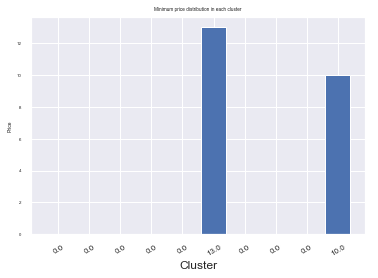

In [85]:
plt.bar(min_price_groups['cluster'], min_price_groups['price'])
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Price', fontsize=5)
plt.xticks(min_price_groups['cluster'], min_price_groups['price'], fontsize=8, rotation=30)
plt.title('Minimum price distribution in each cluster')
plt.show()

<h4>Hosts with multiple listings</h4>

Here we are going to try and find out if we have hosts that entertain multiple listings on AirBnB. These hosts could be either part of a professional company that owns multiple locations or maybe something else.

In [87]:
hosts = master_df.groupby(["host_id"]).count().reset_index()[["host_id","id"]].sort_values(by=["id"],ascending=False).reset_index(drop=True)
hosts_multiple_listings = hosts[hosts["id"]>1]

Let's check how many hosts have multiple listings, then we will also check how many unique hosts we have in total.

In [88]:
print(len(hosts_multiple_listings))

16819


In [89]:
unique_hosts = master_df.host_id.unique()
print(len(unique_hosts))

18850


It looks like the difference between the number of host that have multiple listings and the total number of hosts is not that big. Let's see how the data looks for hosts that have listed multiple properties.

In [90]:
hosts_multiple_listings.head().T

0         1       2         3        4
host_id  1919294  12742095  534666  43488381  2479385
id           794       745     489       481      407

In [91]:
hosts_many_listings = hosts_multiple_listings.loc[hosts_multiple_listings['id'] > 100]
hosts_many_listings.reset_index(inplace=True)
hosts_many_listings.head()

index   host_id   id
0      0   1919294  794
1      1  12742095  745
2      2    534666  489
3      3  43488381  481
4      4   2479385  407

In [92]:
print(len(hosts_many_listings))

91


We can see above that we found 91 hosts that have over 100 listings on AirBnB. Let's do a bar plot.

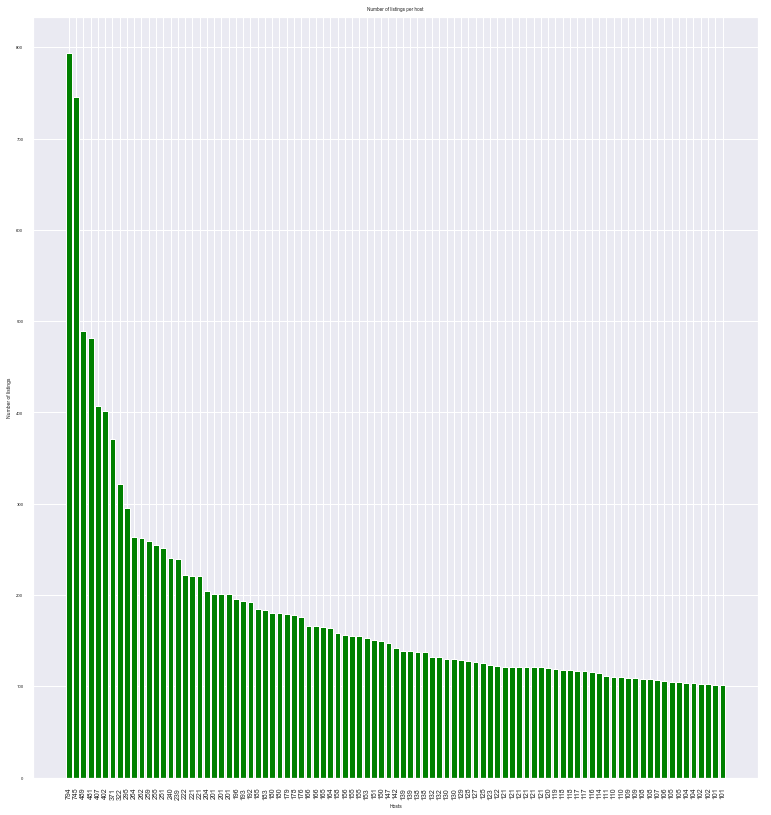

In [94]:
plt.figure(figsize=(13,14))
plt.bar(hosts_many_listings['index'], hosts_many_listings['id'], color='green')
plt.xlabel('Hosts', fontsize=5)
plt.ylabel('Number of listings', fontsize=5)
plt.xticks(hosts_many_listings['index'], hosts_many_listings['id'], fontsize=7, rotation=90)
plt.title('Number of listings per host')
#plt.xticks([])
plt.show()

Very interesting. Some hosts seem to be doing this on a very large scale. Maybe we should plot on a map where thse properties are located.

In [95]:
hosts_many_listings = hosts_multiple_listings.loc[hosts_multiple_listings['id'] > 300]
hosts_many_listings.reset_index(inplace=True)
hosts_many_listings.head(n=8)

index   host_id   id
0      0   1919294  794
1      1  12742095  745
2      2    534666  489
3      3  43488381  481
4      4   2479385  407
5      5  49288354  402
6      6  26743967  371
7      7  33238402  322

In [96]:
print(len(hosts_many_listings))

8


It looks like we have only 8 hosts that own over 300 listings. Maybe we should check what is the total number of listings

In [97]:
total_listings = hosts_many_listings['id'].sum()
print(total_listings)

4011


These 8 hosts have a total of 4011 listings. Maybe we should try to plot them on a map just to see if we can notice something.

In [98]:
listings_dict = {}

for key in hosts_many_listings.host_id:

    listings_dict[key] = master_df.loc[master_df['host_id'] == key]

How many of these listings are real and how many are duplicates? Let's try to find out.

In [99]:
lat_long_dict = {}
for key, value in listings_dict.items():
    #listings_dict[key] = value.groupby(['latitude', 'longitude']).size().reset_index()
    lat_long_dict[key] = value.groupby(['latitude', 'longitude']).size().to_frame(name='count').reset_index()
#    listings_dict[key] = pd.DataFrame({'count' : value.groupby(['latitude', 'longitude']).size()}).reset_index()
    print('Host ' + str(key) + ' listings ' + str(len(lat_long_dict[key])))

Host 1919294 listings 176
Host 12742095 listings 209
Host 534666 listings 126
Host 43488381 listings 229
Host 2479385 listings 91
Host 49288354 listings 106
Host 26743967 listings 89
Host 33238402 listings 106


Interesting, why would somebody have multiple listings for the same location? I will plot these locations on the map.

In [100]:
for key, value in lat_long_dict.items():
    print(value.head(n=8).T)
    print(key)
    break

                   0         1         2          3          4         5  \
latitude   43.621098  43.62110  43.62306  43.623061  43.624237  43.62424   
longitude -79.480743 -79.48074 -79.48326 -79.483263 -79.484251 -79.48425   
count       6.000000   1.00000   1.00000   7.000000   6.000000   1.00000   

                   6         7  
latitude   43.624317  43.62432  
longitude -79.482683 -79.48268  
count       7.000000   1.00000  
1919294


In [119]:
import folium
#master_df.reset_index(inplace=True)

myLat = 43.6823098050454
myLon = -79.3283423644293

city_map = folium.Map(location=[myLat,myLon], tiles="cartodbpositron", zoom_start=15)

color_scale = np.array(['#053061','#2166ac','#4393c3','#92c5de','#d1e5f0','#fddbc7','#f4a582','#d6604d','#b2182b','#67001f'])
cs_count = 0

for key in lat_long_dict.keys():
    
    vals = lat_long_dict[key]
    
    for i in range(0, len(vals)):
        
        lat = vals.iloc[i]['latitude']
        long = vals.iloc[i]['longitude']

        records = master_df[(master_df['host_id'] == key) & (master_df['latitude'] == lat) & (master_df['longitude'] == long)]
        
        hosts_names = []
        prices = []
        room_types = []
        host_ids = []
        
        for j in range(0, len(records)):
            
            hn = records.iloc[j]['host_name']
            pp = records.iloc[j]['price']
            rt = records.iloc[j]['property_type']
            hid = records.iloc[j]['host_id']
            
            if hn not in hosts_names:
                hosts_names.append(hn)
            if pp not in prices:
                prices.append(str(pp))
            if rt not in room_types:
                room_types.append(rt)
            if str(hid) not in host_ids:
                host_ids.append(str(hid))
                
        hn_string = ','.join(hosts_names)
        pp_string = ','.join(prices)
        rt_string = ','.join(room_types)
        hid_string = ','.join(host_ids)
        
        pop_str = 'Host ID: ' + hid_string + "\n"
        pop_str += 'Host Name: ' + hn_string + "\n"
        pop_str += 'Price: ' + pp_string + "\n"
        pop_str += 'Room type: ' + rt_string
 
        
        folium.Circle(
          location=[vals.iloc[i]['latitude'], vals.iloc[i]['longitude']],
          radius=3*vals.iloc[i]['count'],
          popup=str(key) + ' Num Listings ' + str(vals.iloc[i]['count'])  + ' ' + pop_str,
          color=color_scale[cs_count],
          fill=True,
          fill_color='crimson'
           ).add_to(city_map)
    
    cs_count += 1

city_map

I believe this is very interesting. We can see above that we have some hosts that would list the same property multiple times at different prices. I also briefly checked the yearly availability of different listings and I realized that different listings have different availability troughout the year. It looks like most of these rentals would be appartments.

<h3>Combine outliers detected from different methods</h3>

Try to combine all outliers that we have found so far. We are going to make an attempt to understand them.

In [102]:
price_outliers = master_df.loc[master_df['price'] > 500]
print(len(price_outliers))

3780


In [103]:
outliers_covariance = master_df[decisionsRobustCovariance < 0]

In [104]:
outliers_svm = master_df[decisionsOneClassSVM < 0]

In [105]:
print(len(outliers_covariance))
print(len(outliers_svm))

198
572


In [106]:
hosts_multiple_listings_list = hosts_many_listings['host_id'].tolist()
multiple_listings_outliers = master_df[master_df['host_id'].isin(hosts_multiple_listings_list)]

print(len(multiple_listings_outliers))

4011


After obtaining the above four different outliers classes we should try first to intersect them and find if we have any common rows in all of them.

In [107]:
price_multiple_listings_outliers = pd.merge(price_outliers, multiple_listings_outliers, on='id', how='inner')
print(len(price_multiple_listings_outliers))

17


We can see a few listings that are contained in both dataframes. Let's check them out.

In [108]:
price_multiple_listings_outliers.head().T

0  \
index_x                                                                   8410   
id                                                                     5171066   
name_x                                                    charming house annex   
summary_x                    convenient calm lively private may sound impos...   
description_x                convenient calm lively private may sound impos...   
host_id_x                                                             26743967   
host_name_x                                        Toronto Heritage Residences   
host_since_x                                                        2015-01-26   
host_location_x                                       Toronto, Ontario, Canada   
host_about_x                 Would you like the freedom to explore downtown...   
host_is_superhost_x                                                          0   
host_listings_count_x                                                       57   
host_total_listings_count_x                                                 57   
host_identity_verified_x                                                     1   
street_x                                                   Toronto, ON, Canada   
neighbourhood_x                                                      The Annex   
neighbourhood_cleansed_x                                                 Annex   
latitude_x                                                             43.6721   
longitude_x                                                           -79.4029   
is_location_exact_x                                                          1   
property_type_x                                                     Guesthouse   
room_type_x                                                    Entire home/apt   
accommodates_x                                                              12   
bathrooms_x                                                                  3   
bedrooms_x                                                                   9   
beds_x                                                                      11   
bed_type_x                                                            Real Bed   
amenities_x                  internet wifi air conditioning kitchen heating...   
price_x                                                                    700   
guests_included_x                                                           10   
...                                                                        ...   
description_y                convenient calm lively private may sound impos...   
host_id_y                                                             26743967   
host_name_y                                        Toronto Heritage Residences   
host_since_y                                                        2015-01-26   
host_location_y                                       Toronto, Ontario, Canada   
host_about_y                 Would you like the freedom to explore downtown...   
host_is_superhost_y                                                          0   
host_listings_count_y                                                       57   
host_total_listings_count_y                                                 57   
host_identity_verified_y                                                     1   
street_y                                                   Toronto, ON, Canada   
neighbourhood_y                                                      The Annex   
neighbourhood_cleansed_y                                                 Annex   
latitude_y                                                             43.6721   
longitude_y                                                           -79.4029   
is_location_exact_y                                                          1   
property_type_y                                                     Guesthouse   
room_type_y                                                

I found it interesting that for the listings above we have availability 365 set to zero. What's the meaning of it? I will plot this on a map and try to reveal more details about it. However first I would like check how many unique hosts are included in the values intersection.

In [109]:
price_multiple_listings_outliers['host_id_x'].nunique()

2

In [124]:
import folium
#master_df.reset_index(inplace=True)

myLat = 43.6823098050454
myLon = -79.3283423644293

city_map = folium.Map(location=[myLat,myLon], tiles="cartodbpositron", zoom_start=15)

color_scale = np.array(['#053061','#2166ac','#4393c3','#92c5de','#d1e5f0','#fddbc7','#f4a582','#d6604d','#b2182b','#67001f'])
cs_count = 0

for i in range(0,len(price_multiple_listings_outliers)):
    
    pop_str = 'Host ID: ' + str(price_multiple_listings_outliers.iloc[i]['host_id_x']) + "\n"
    pop_str += 'Host Name: ' + str(price_multiple_listings_outliers.iloc[i]['host_name_x']) + "\n"
#    pop_str += 'Host url: ' + price_multiple_listings_outliers.iloc[i]['host_url_x'] + "\n"
    pop_str += 'Price: ' + str(price_multiple_listings_outliers.iloc[i]['price_x']) + "\n"
    pop_str += 'Property type: ' + str(price_multiple_listings_outliers.iloc[i]['property_type_x']) + "\n"
#    pop_str += 'Listing url: ' + str(price_multiple_listings_outliers.iloc[i]['listing_url_x']) + "\n"
    pop_str +=' Accomodates: ' + str(price_multiple_listings_outliers.iloc[i]['accommodates_x']) 
    pop_str +=' Availability: ' + str(price_multiple_listings_outliers.iloc[i]['availability_365_x'])

    
    folium.Circle(
          location=[price_multiple_listings_outliers.iloc[i]['latitude_x'], price_multiple_listings_outliers.iloc[i]['longitude_x']],
          radius=5,
          popup=pop_str,
          color='crimson',
          fill=True,
          fill_color='crimson'
           ).add_to(city_map)
    

#print(count)
city_map

Now let's try to find out if we have any commonalities between the SVM and covariance outliers.

In [111]:
covariance_svm_intersection = pd.merge(outliers_svm, outliers_covariance, on='id', how='inner')
print(len(covariance_svm_intersection))

574


It looks SVM outliers include all covariance outliers. Let's plot them on a map and display same features like the ones displayed above.

In [126]:
myLat = 43.6823098050454
myLon = -79.3283423644293

city_map = folium.Map(location=[myLat,myLon], tiles="cartodbpositron", zoom_start=15)

color_scale = np.array(['#053061','#2166ac','#4393c3','#92c5de','#d1e5f0','#fddbc7','#f4a582','#d6604d','#b2182b','#67001f'])
cs_count = 0

for i in range(0,len(outliers_svm)):
    
    pop_str = 'Host ID: ' + str(outliers_svm.iloc[i]['host_id']) + "\n"
    pop_str += 'Host Name: ' + str(outliers_svm.iloc[i]['host_name']) + "\n"
#    pop_str += 'Host url: ' + outliers_svm.iloc[i]['host_url'] + "\n"
    pop_str += 'Price: ' + str(outliers_svm.iloc[i]['price']) + "\n"
    pop_str += 'Property type: ' + str(outliers_svm.iloc[i]['property_type']) + "\n"
#    pop_str += 'Listing url: ' + str(outliers_svm.iloc[i]['listing_url']) + "\n"
    pop_str +=' Accomodates: ' + str(outliers_svm.iloc[i]['accommodates']) 
    pop_str +=' Availability: ' + str(outliers_svm.iloc[i]['availability_365'])
    
    
    folium.Circle(
          location=[outliers_svm.iloc[i]['latitude'], outliers_svm.iloc[i]['longitude']],
          radius=5,
          popup=pop_str,
          color='crimson',
          fill=True,
          fill_color='crimson'
           ).add_to(city_map)
    

#print(count)
city_map

In [ ]:
outliers_svm.to_csv('outliers_svm.csv')
price_multiple_listings_outliers.to_csv('outliers_price.csv')

Try to load the processed review features for the outliers, the run  DBSCAN clustering on this data and plot each cluster on a map.

In [127]:
import numpy as np 
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
import re

In [128]:
def ProcessFeatures(values):
    values = values.replace('[', '')
    values = values.replace(']', '')
    values = values.replace('\n', '')
    
    values_clean = re.sub(' +', ' ', values)
#    values_clean =" ".join(values.split())
#    text_data = values
#    text_data = re.sub('[\s]+', ' ', text_data)
#    text_data = re.sub('[\n]+', ' ', text_data)
    #remove not alphanumeric symbols white spaces
#    text_data = re.sub(r'[^\w]+', ' ', text_data)
    values_clean = values_clean.strip(' \t\n\r')
    
    
    split_values = values_clean.split(' ')
    
#    print(split_values)
#    print(len(split_values)) 
    
#    print('||'  + values_clean + '\\')
    
    return [float(i) for i in split_values]

In [129]:
reviews_features = pd.read_csv('./data/generated/outlier_reviews.csv.gz', low_memory=False, compression='gzip')
reviews_features['features'] = reviews_features['features'].apply(ProcessFeatures)
#master_df = pd.read_csv('data_features_clean.csv')

X3 = []

for itm in reviews_features['features']:
   X3.append(itm)

np.array(reviews_features['features'])

X3 = np.array(X3)

print('DB start')
db = DBSCAN(eps=0.5, min_samples=5, metric='cosine').fit(X3)
print('DB end')

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

#np.zeros_like(db.labels_, dtype=bool)

#range(len(np.array(labels)))

np.array(labels)

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_) 


DB start
DB end
Estimated number of clusters: 6
Estimated number of noise points: 4


In [130]:
master_df = pd.read_csv('./data/generated/data_features_clean.csv.gz', low_memory=False, compression='gzip')

In [131]:
master_df.head(1).T

0
Unnamed: 0                                                                 0
Unnamed: 0.1                                                               0
id                                                                  24084526
name                            large sunny room queen sized bed near subway
summary                    private room luxury queen sized bed located qu...
description                private room luxury queen sized bed located qu...
host_id                                                            157408457
host_name                                                      Lisa & Benson
host_since                                                        2017-11-04
host_location                                                             CA
host_about                 Hi we are Lisa and Benson, \r\nWe welcome you ...
host_is_superhost                                                          0
host_listings_count                                                        7
host_total_listings_count                                                  7
host_identity_verified                                                     0
street                                                   Toronto, ON, Canada
neighbourhood                                        York University Heights
neighbourhood_cleansed                               York University Heights
latitude                                                             43.7526
longitude                                                           -79.5077
is_location_exact                                                          1
property_type                                                          House
room_type                                                       Private room
accommodates                                                               2
bathrooms                                                                  1
bedrooms                                                                   1
beds                                                                       1
bed_type                                                            Real Bed
amenities                  wifi air conditioning kitchen free parking pre...
price                                                                     40
guests_included                                                            1
extra_people                                                              10
availability_365                                                         171
desc_features              ['-0.106930874', '-0.03466785', '-0.037711095'...

Noe let's check any property that has a price higher than $1000 and is almost always available.

In [133]:
import folium
myLat = 43.6823098050454
myLon = -79.3283423644293

days_map1 = folium.Map(location=[myLat,myLon], tiles="cartodbpositron", zoom_start=15)

for i in range(0,len(master_df)):
    if master_df.iloc[i]['availability_365'] > 300 and master_df.iloc[i]['price'] > 1000:

        pop_str = 'Host ID: ' + str(master_df.iloc[i]['host_id']) + "\n"
        pop_str += 'Host Name: ' + str(master_df.iloc[i]['host_name']) + "\n"
#        pop_str += 'Host url: ' + master_df.iloc[i]['host_url'] + "\n"
        pop_str += 'Price: ' + str(master_df.iloc[i]['price']) + "\n"
        pop_str += 'Property type: ' + str(master_df.iloc[i]['property_type']) + "\n"
#        pop_str += 'Listing url: ' + str(master_df.iloc[i]['listing_url']) + "\n"
        pop_str +=' Accomodates: ' + str(master_df.iloc[i]['accommodates']) 
        pop_str +=' Availability: ' + str(master_df.iloc[i]['availability_365'])



        folium.Circle(
          location=[master_df.iloc[i]['latitude'], master_df.iloc[i]['longitude']],
          radius=master_df.iloc[i]['price']/400,
          popup=pop_str,
          color='crimson',
          fill=True,
          fill_color='crimson'
           ).add_to(days_map1)
    

#print(count)
days_map1

The plot below represents listings at the same physical location (lat/long) that seem to appear under different hosts ID. In case of a condominium this is something natural but in other cases it might point to something else.

In [136]:
import pandas as pd
import folium
multiple_host = pd.read_csv('./data/generated/multiple_hosts_per_latlon_with_listing.csv')

myLat = 43.6823098050454
myLon = -79.3283423644293

days_map1 = folium.Map(location=[myLat,myLon], tiles="cartodbpositron", zoom_start=15)
#count = 0
for i in range(0,len(multiple_host)):
    
    if multiple_host.iloc[i]['property_type'] == 'Condominium':
        folium.Circle(
          location=[multiple_host.iloc[i]['latitude'], multiple_host.iloc[i]['longitude']],
          radius=5,
          popup=str(multiple_host.iloc[i]['count']) + ' ' + multiple_host.iloc[i]['property_type'] + ' ' + multiple_host.iloc[i]['room_type'] ,
          color='crimson',
          fill=True,
          fill_color='crimson'
           ).add_to(days_map1)
    else:
        folium.Circle(
          location=[multiple_host.iloc[i]['latitude'], multiple_host.iloc[i]['longitude']],
          radius=5,
          popup=str(multiple_host.iloc[i]['count']) + ' ' + multiple_host.iloc[i]['property_type'] + ' ' + multiple_host.iloc[i]['room_type'] + ' ' + str(multiple_host.iloc[i]['id']) ,
          color='blue',
          fill=True,
          fill_color='blue'
           ).add_to(days_map1)


#print(count)
days_map1

We have identified that property ID 20785810 doesn't have any review yet. After a brief analysis of this host calendar we realized that the property has been listed since 2018-04-09 until 2020-03-05 but the calendar listings don't have any price for the entire period of time. Also his profile picture doesn't appear to be genuine and a brief online search of this host ended up empty. 

We are going to focus now on listings that have no reviews.

In [137]:
listings_few_reviews = pd.read_csv('./data/generated/listings_with_le1_reviews.csv')

In [138]:
listings_few_reviews.head().T

0  \
host_id                                                             48239   
host_url                          https://www.airbnb.com/users/show/48239   
host_name                                                            Rona   
id                                                                  12604   
latitude                                                          43.6672   
longitude                                                         -79.416   
number_of_reviews                                                       0   
price                                                              $67.00   
property_type                                                       House   
thumbnail_url                                                         NaN   
listing_url                            https://www.airbnb.com/rooms/12604   
host_picture_url        https://a0.muscache.com/im/users/48239/profile...   
host_is_superhost                                                       f   
host_identity_verified                                                  t   

                                                                        1  \
host_id                                                             22795   
host_url                          https://www.airbnb.com/users/show/22795   
host_name                                                  Kathie & Larry   
id                                                                  30931   
latitude                                                          43.6415   
longitude                                                        -79.3764   
number_of_reviews                                                       1   
price                                                             $134.00   
property_type                                                   Apartment   
thumbnail_url                                                         NaN   
listing_url                            https://www.airbnb.com/rooms/30931   
host_picture_url        https://a0.muscache.com/im/pictures/9a077853-c...   
host_is_superhost                                                       f   
host_identity_verified                                                  f   

                                                                        2  \
host_id                                                            187320   
host_url                         https://www.airbnb.com/users/show/187320   
host_name                                           Downtown Suite Living   
id                                                                  57483   
latitude                                                          43.6421   
longitude                                                        -79.3799   
number_of_reviews                                                       0   
price                                                             $177.00   
property_type                                                 Condominium   
thumbnail_url                                                         NaN   
listing_url                            https://www.airbnb.com/rooms/57483   
host_picture_url        https://a0.muscache.com/im/users/187320/profil...   
host_is_superhost                                                       t   
host_identity_verified                                                  t   

                                                                        3  \
host_id                                                            187320   
host_url                         https://www.airbnb.com/users/show/187320   
host_name                                           Downtown Suite Living   
id                                                                  63395   
latitude                                                          43.6453   
longitude                                                        -79.3761   
number_of_reviews                                                

In [139]:
myLat = 43.6823098050454
myLon = -79.3283423644293

days_map1 = folium.Map(location=[myLat,myLon], tiles="cartodbpositron", zoom_start=15)
#count = 0
end = int(len(listings_few_reviews)/10)
for i in range(0,end):
    pop_str = 'Host ID: ' + str(listings_few_reviews.iloc[i]['host_id']) + "\n"
    pop_str += 'Host Name: ' + str(listings_few_reviews.iloc[i]['host_name']) + "\n"
    pop_str += 'Host url: ' + str(listings_few_reviews.iloc[i]['host_url']) + "\n"
    pop_str += 'Price: ' + str(listings_few_reviews.iloc[i]['price']) + "\n"
    pop_str += 'property_type: ' + str(listings_few_reviews.iloc[i]['property_type']) + "\n"
    pop_str += 'thumbnail_url: ' + str(listings_few_reviews.iloc[i]['thumbnail_url']) + "\n"
    pop_str += 'listing_url: ' + str(listings_few_reviews.iloc[i]['listing_url']) + "\n"
    pop_str += 'host_picture_url: ' + str(listings_few_reviews.iloc[i]['host_picture_url']) + "\n"
    pop_str += 'host_is_superhost' + str(listings_few_reviews.iloc[i]['host_is_superhost'])
    
    
    folium.Circle(
      location=[listings_few_reviews.iloc[i]['latitude'], listings_few_reviews.iloc[i]['longitude']],
      radius=5,
      popup=pop_str ,
      color='blue',
      fill=True,
      fill_color='blue'
       ).add_to(days_map1)


#print(count)
days_map1